In [1]:
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

# Simulaciones

In [2]:
path = 'data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {15190, 1003206, 16503, 15004, 14062, 13735, 1003167, 1003744, 1003746, 1003950, 13730, 13731, 13732, 13733, 15131, 16094, 16095, 131099}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1
    
## Lectura de Grafo dirigido original

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
        
        
###################################################################################################

        
path = 'data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

## Lectura de Árbol dirigido

T = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        T.add_edge(id_[origin], id_[dest])
        
###################################################################################################

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

## Simulación usando programación dinámica

In [30]:
# Primero se obtiene solución común a primera separación (para no caclularla en cada simulación)

init_possibilities, init_next_dicts = get_dp_table(T, [0] * N, 8, 743, 50)

In [38]:
def simulate(G, W, k_list, s_init):
    
    T = []  # Lista que guarda cantidad de iteraciones usadas en encontrar cada nodo
    
    N = len(W)

    for r in range(N): # Para cada nodo simulamos
        
        # Se marcan los nodos donde sería detectable COVID propagando según el grafo
        
        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)
                    
        # Inicio de simulación

        V = [0] * N  # 1: nodos descartados en la búsqueda, 0: potenciales

        R = N; s = s_init
        for t in range(100):
            
            # Primero se obtiene la muestra usando el algoritmo de programación dinámica
            
            P = []; k = k_list[-1]
            if t < len(k_list):
                k = k_list[t]
            if t == 0:
                P, _ = get_sample_from_table(G, init_possibilities, init_next_dicts, V, k, s)
            elif N - sum(V) > 200:
                new_possibilities, new_next_dicts = get_dp_table(G, V, k, s, 20)
                P, _ = get_sample_from_table(G, new_possibilities, new_next_dicts, V, k, s)
            elif N - sum(V) > 10:
                new_possibilities, new_next_dicts = get_dp_table(G, V, k, s, 10)
                P, _ = get_sample_from_table(G, new_possibilities, new_next_dicts, V, k, s)
            else:
                new_possibilities, new_next_dicts = get_dp_table(G, V, min(k, N - sum(V)), s, 1)
                P, _ = get_sample_from_table(G, new_possibilities, new_next_dicts, V, min(k, N - sum(V)), s)
                
            # Descartamos nodos según resultados en cada muestra
                
            for u in P[::-1]:
                if CV[u]:
                    I = set(get_ideal(G, V, u)[::-1])
                    V = [not (v in I) for v in range(N)]
                    s = u; break
                else:
                    V, _ = visit(G, V, u)
                    
            # Verificamos condición de término

            size, weight = get_size_weight(G, W, V, s)

            if size == 1 or weight <= 200:
                T.append(t + 1)
                print(f"Result {r}: {T[-1]}    acc: {sum(T) / (r + 1)}")
                break
            if t == 99:
                T.append(100)
                print(f"Result {r}: {T[-1]}    acc: {sum(T) / (r + 1)}")

    print(sum(T) / len(T), max(T))
    
    return T


In [44]:
iters = simulate(T, W, [8, 5], 743)

Result 0: 5    acc: 5.0
Result 1: 5    acc: 5.0
Result 2: 4    acc: 4.666666666666667
Result 3: 4    acc: 4.5
Result 4: 5    acc: 4.6
Result 5: 5    acc: 4.666666666666667
Result 6: 5    acc: 4.714285714285714
Result 7: 5    acc: 4.75
Result 8: 5    acc: 4.777777777777778
Result 9: 5    acc: 4.8
Result 10: 5    acc: 4.818181818181818
Result 11: 5    acc: 4.833333333333333
Result 12: 5    acc: 4.846153846153846
Result 13: 5    acc: 4.857142857142857
Result 14: 1    acc: 4.6
Result 15: 1    acc: 4.375
Result 16: 1    acc: 4.176470588235294
Result 17: 1    acc: 4.0
Result 18: 1    acc: 3.8421052631578947
Result 19: 5    acc: 3.9
Result 20: 5    acc: 3.9523809523809526
Result 21: 5    acc: 4.0
Result 22: 5    acc: 4.043478260869565
Result 23: 5    acc: 4.083333333333333
Result 24: 1    acc: 3.96
Result 25: 4    acc: 3.9615384615384617
Result 26: 5    acc: 4.0
Result 27: 5    acc: 4.035714285714286
Result 28: 5    acc: 4.068965517241379
Result 29: 5    acc: 4.1
Result 30: 5    acc: 4.129032

Result 220: 4    acc: 4.46606334841629
Result 221: 4    acc: 4.463963963963964
Result 222: 4    acc: 4.461883408071749
Result 223: 4    acc: 4.459821428571429
Result 224: 5    acc: 4.4622222222222225
Result 225: 5    acc: 4.464601769911504
Result 226: 5    acc: 4.466960352422907
Result 227: 5    acc: 4.469298245614035
Result 228: 5    acc: 4.471615720524017
Result 229: 5    acc: 4.473913043478261
Result 230: 5    acc: 4.476190476190476
Result 231: 5    acc: 4.478448275862069
Result 232: 5    acc: 4.48068669527897
Result 233: 4    acc: 4.478632478632479
Result 234: 4    acc: 4.476595744680851
Result 235: 5    acc: 4.478813559322034
Result 236: 4    acc: 4.476793248945148
Result 237: 4    acc: 4.474789915966387
Result 238: 3    acc: 4.468619246861925
Result 239: 4    acc: 4.466666666666667
Result 240: 4    acc: 4.464730290456432
Result 241: 4    acc: 4.462809917355372
Result 242: 3    acc: 4.45679012345679
Result 243: 5    acc: 4.459016393442623
Result 244: 5    acc: 4.461224489795918
Re

Result 426: 5    acc: 4.224824355971897
Result 427: 3    acc: 4.22196261682243
Result 428: 3    acc: 4.2191142191142195
Result 429: 4    acc: 4.21860465116279
Result 430: 4    acc: 4.218097447795824
Result 431: 5    acc: 4.219907407407407
Result 432: 4    acc: 4.219399538106235
Result 433: 4    acc: 4.21889400921659
Result 434: 3    acc: 4.216091954022988
Result 435: 5    acc: 4.217889908256881
Result 436: 6    acc: 4.221967963386728
Result 437: 6    acc: 4.226027397260274
Result 438: 5    acc: 4.2277904328018225
Result 439: 5    acc: 4.2295454545454545
Result 440: 4    acc: 4.229024943310658
Result 441: 4    acc: 4.228506787330317
Result 442: 4    acc: 4.227990970654628
Result 443: 5    acc: 4.22972972972973
Result 444: 4    acc: 4.229213483146068
Result 445: 4    acc: 4.228699551569507
Result 446: 5    acc: 4.230425055928412
Result 447: 3    acc: 4.227678571428571
Result 448: 3    acc: 4.224944320712694
Result 449: 3    acc: 4.222222222222222
Result 450: 3    acc: 4.219512195121951
R

Result 634: 4    acc: 4.239370078740158
Result 635: 4    acc: 4.238993710691824
Result 636: 4    acc: 4.23861852433281
Result 637: 4    acc: 4.238244514106583
Result 638: 4    acc: 4.237871674491393
Result 639: 4    acc: 4.2375
Result 640: 4    acc: 4.237129485179407
Result 641: 4    acc: 4.2367601246105915
Result 642: 4    acc: 4.236391912908243
Result 643: 4    acc: 4.236024844720497
Result 644: 4    acc: 4.235658914728682
Result 645: 4    acc: 4.235294117647059
Result 646: 4    acc: 4.234930448222566
Result 647: 5    acc: 4.236111111111111
Result 648: 4    acc: 4.2357473035439135
Result 649: 4    acc: 4.235384615384615
Result 650: 3    acc: 4.233486943164363
Result 651: 4    acc: 4.233128834355829
Result 652: 5    acc: 4.234303215926493
Result 653: 3    acc: 4.232415902140673
Result 654: 4    acc: 4.23206106870229
Result 655: 3    acc: 4.2301829268292686
Result 656: 5    acc: 4.231354642313547
Result 657: 5    acc: 4.232522796352583
Result 658: 3    acc: 4.2306525037936265
Result 65

Result 840: 4    acc: 4.1771700356718195
Result 841: 4    acc: 4.176959619952494
Result 842: 5    acc: 4.177935943060498
Result 843: 5    acc: 4.178909952606635
Result 844: 5    acc: 4.179881656804734
Result 845: 5    acc: 4.180851063829787
Result 846: 5    acc: 4.181818181818182
Result 847: 4    acc: 4.181603773584905
Result 848: 4    acc: 4.181389870435807
Result 849: 5    acc: 4.182352941176471
Result 850: 5    acc: 4.18331374853114
Result 851: 5    acc: 4.184272300469484
Result 852: 4    acc: 4.184056271981243
Result 853: 5    acc: 4.1850117096018735
Result 854: 4    acc: 4.184795321637427
Result 855: 4    acc: 4.184579439252336
Result 856: 4    acc: 4.18436406067678
Result 857: 4    acc: 4.1841491841491845
Result 858: 4    acc: 4.183934807916182
Result 859: 4    acc: 4.183720930232558
Result 860: 4    acc: 4.183507549361208
Result 861: 4    acc: 4.183294663573085
Result 862: 4    acc: 4.183082271147161
Result 863: 4    acc: 4.18287037037037
Result 864: 4    acc: 4.182658959537572


Result 1045: 4    acc: 4.124282982791587
Result 1046: 4    acc: 4.1241642788920725
Result 1047: 4    acc: 4.124045801526718
Result 1048: 4    acc: 4.123927550047664
Result 1049: 4    acc: 4.123809523809523
Result 1050: 4    acc: 4.1236917221693625
Result 1051: 4    acc: 4.123574144486692
Result 1052: 4    acc: 4.1234567901234565
Result 1053: 4    acc: 4.1233396584440225
Result 1054: 4    acc: 4.123222748815166
Result 1055: 3    acc: 4.122159090909091
Result 1056: 4    acc: 4.122043519394513
Result 1057: 4    acc: 4.121928166351607
Result 1058: 4    acc: 4.121813031161473
Result 1059: 4    acc: 4.121698113207547
Result 1060: 4    acc: 4.121583411875589
Result 1061: 4    acc: 4.121468926553672
Result 1062: 6    acc: 4.123236124176858
Result 1063: 4    acc: 4.1231203007518795
Result 1064: 3    acc: 4.122065727699531
Result 1065: 5    acc: 4.122889305816135
Result 1066: 4    acc: 4.122774133083412
Result 1067: 4    acc: 4.122659176029963
Result 1068: 5    acc: 4.123479887745557
Result 1069

Result 1245: 5    acc: 4.117174959871589
Result 1246: 5    acc: 4.117882919005614
Result 1247: 6    acc: 4.1193910256410255
Result 1248: 6    acc: 4.120896717373899
Result 1249: 6    acc: 4.1224
Result 1250: 6    acc: 4.123900879296563
Result 1251: 5    acc: 4.124600638977636
Result 1252: 5    acc: 4.125299281723863
Result 1253: 5    acc: 4.1259968102073366
Result 1254: 5    acc: 4.126693227091634
Result 1255: 4    acc: 4.126592356687898
Result 1256: 4    acc: 4.126491646778043
Result 1257: 4    acc: 4.126391096979332
Result 1258: 4    acc: 4.126290706910246
Result 1259: 4    acc: 4.126190476190477
Result 1260: 4    acc: 4.12609040444092
Result 1261: 4    acc: 4.125990491283677
Result 1262: 4    acc: 4.1258907363420425
Result 1263: 5    acc: 4.1265822784810124
Result 1264: 5    acc: 4.127272727272727
Result 1265: 5    acc: 4.127962085308057
Result 1266: 5    acc: 4.128650355169692
Result 1267: 5    acc: 4.129337539432177
Result 1268: 5    acc: 4.130023640661938
Result 1269: 5    acc: 4

Result 1447: 5    acc: 4.148480662983426
Result 1448: 5    acc: 4.149068322981367
Result 1449: 4    acc: 4.148965517241379
Result 1450: 4    acc: 4.148862853204687
Result 1451: 4    acc: 4.148760330578512
Result 1452: 4    acc: 4.148657949070888
Result 1453: 4    acc: 4.148555708390647
Result 1454: 4    acc: 4.148453608247423
Result 1455: 4    acc: 4.148351648351649
Result 1456: 4    acc: 4.14824982841455
Result 1457: 4    acc: 4.148148148148148
Result 1458: 4    acc: 4.14804660726525
Result 1459: 4    acc: 4.147945205479452
Result 1460: 4    acc: 4.147843942505133
Result 1461: 4    acc: 4.147742818057456
Result 1462: 4    acc: 4.147641831852358
Result 1463: 4    acc: 4.147540983606557
Result 1464: 4    acc: 4.147440273037542
Result 1465: 4    acc: 4.147339699863575
Result 1466: 4    acc: 4.147239263803681
Result 1467: 4    acc: 4.147138964577657
Result 1468: 4    acc: 4.147038801906058
Result 1469: 4    acc: 4.146938775510204
Result 1470: 4    acc: 4.146838885112168
Result 1471: 4    

Result 1648: 4    acc: 4.154639175257732
Result 1649: 5    acc: 4.155151515151515
Result 1650: 5    acc: 4.1556632344033915
Result 1651: 5    acc: 4.156174334140436
Result 1652: 5    acc: 4.156684815486994
Result 1653: 5    acc: 4.157194679564691
Result 1654: 5    acc: 4.157703927492447
Result 1655: 5    acc: 4.158212560386473
Result 1656: 5    acc: 4.158720579360289
Result 1657: 5    acc: 4.159227985524729
Result 1658: 5    acc: 4.159734779987945
Result 1659: 5    acc: 4.160240963855422
Result 1660: 5    acc: 4.160746538229982
Result 1661: 5    acc: 4.161251504211793
Result 1662: 5    acc: 4.161755862898376
Result 1663: 5    acc: 4.162259615384615
Result 1664: 5    acc: 4.162762762762763
Result 1665: 5    acc: 4.163265306122449
Result 1666: 5    acc: 4.16376724655069
Result 1667: 5    acc: 4.164268585131895
Result 1668: 5    acc: 4.164769322947873
Result 1669: 4    acc: 4.164670658682635
Result 1670: 4    acc: 4.16457211250748
Result 1671: 4    acc: 4.1644736842105265
Result 1672: 5  

Result 1848: 4    acc: 4.169280692266089
Result 1849: 4    acc: 4.169189189189189
Result 1850: 4    acc: 4.1690977849810915
Result 1851: 4    acc: 4.1690064794816415
Result 1852: 4    acc: 4.168915272531031
Result 1853: 4    acc: 4.168824163969795
Result 1854: 5    acc: 4.169272237196766
Result 1855: 5    acc: 4.169719827586207
Result 1856: 4    acc: 4.169628432956381
Result 1857: 4    acc: 4.169537136706135
Result 1858: 4    acc: 4.1694459386767075
Result 1859: 4    acc: 4.169354838709677
Result 1860: 4    acc: 4.169263836646964
Result 1861: 4    acc: 4.169172932330827
Result 1862: 5    acc: 4.169618894256575
Result 1863: 5    acc: 4.170064377682404
Result 1864: 4    acc: 4.169973190348525
Result 1865: 4    acc: 4.169882100750268
Result 1866: 4    acc: 4.169791108730584
Result 1867: 4    acc: 4.169700214132762
Result 1868: 4    acc: 4.169609416800428
Result 1869: 4    acc: 4.1695187165775405
Result 1870: 4    acc: 4.169428113308391
Result 1871: 5    acc: 4.169871794871795
Result 1872:

Result 2049: 4    acc: 4.189756097560975
Result 2050: 4    acc: 4.189663578742077
Result 2051: 4    acc: 4.189571150097466
Result 2052: 4    acc: 4.1894788114953725
Result 2053: 4    acc: 4.189386562804284
Result 2054: 4    acc: 4.189294403892944
Result 2055: 4    acc: 4.18920233463035
Result 2056: 5    acc: 4.189596499756927
Result 2057: 4    acc: 4.189504373177843
Result 2058: 4    acc: 4.1894123360854785
Result 2059: 4    acc: 4.189320388349515
Result 2060: 4    acc: 4.189228529839884
Result 2061: 4    acc: 4.18913676042677
Result 2062: 4    acc: 4.189045079980611
Result 2063: 4    acc: 4.188953488372093
Result 2064: 4    acc: 4.188861985472155
Result 2065: 4    acc: 4.188770571151984
Result 2066: 4    acc: 4.188679245283019
Result 2067: 4    acc: 4.188588007736944
Result 2068: 6    acc: 4.189463508941517
Result 2069: 5    acc: 4.189855072463768
Result 2070: 3    acc: 4.189280540801545
Result 2071: 3    acc: 4.188706563706564
Result 2072: 4    acc: 4.188615533043897
Result 2073: 4  

Result 2250: 4    acc: 4.134162594402488
Result 2251: 4    acc: 4.1341030195381885
Result 2252: 4    acc: 4.13404349755881
Result 2253: 4    acc: 4.133984028393966
Result 2254: 4    acc: 4.133924611973392
Result 2255: 4    acc: 4.13386524822695
Result 2256: 4    acc: 4.133805937084626
Result 2257: 3    acc: 4.133303808680248
Result 2258: 4    acc: 4.133244798583444
Result 2259: 3    acc: 4.132743362831858
Result 2260: 3    acc: 4.132242370632463
Result 2261: 4    acc: 4.132183908045977
Result 2262: 4    acc: 4.132125497127706
Result 2263: 4    acc: 4.132067137809187
Result 2264: 4    acc: 4.132008830022075
Result 2265: 5    acc: 4.132391879964696
Result 2266: 5    acc: 4.132774591971769
Result 2267: 5    acc: 4.1331569664903
Result 2268: 4    acc: 4.133098281181137
Result 2269: 5    acc: 4.133480176211454
Result 2270: 5    acc: 4.133861734918538
Result 2271: 5    acc: 4.134242957746479
Result 2272: 5    acc: 4.1346238451385835
Result 2273: 5    acc: 4.135004397537379
Result 2274: 5    

Result 2451: 3    acc: 4.125611745513866
Result 2452: 3    acc: 4.125152874031798
Result 2453: 3    acc: 4.124694376528117
Result 2454: 5    acc: 4.125050916496945
Result 2455: 3    acc: 4.124592833876221
Result 2456: 3    acc: 4.124135124135124
Result 2457: 3    acc: 4.1236777868185515
Result 2458: 3    acc: 4.1232208214721435
Result 2459: 3    acc: 4.122764227642277
Result 2460: 3    acc: 4.122308004876067
Result 2461: 3    acc: 4.121852152721365
Result 2462: 3    acc: 4.121396670726756
Result 2463: 3    acc: 4.120941558441558
Result 2464: 3    acc: 4.120486815415822
Result 2465: 3    acc: 4.120032441200324
Result 2466: 3    acc: 4.1195784353465745
Result 2467: 3    acc: 4.1191247974068075
Result 2468: 3    acc: 4.118671526933982
Result 2469: 3    acc: 4.1182186234817815
Result 2470: 3    acc: 4.117766086604614
Result 2471: 3    acc: 4.117313915857605
Result 2472: 3    acc: 4.116862110796603
Result 2473: 3    acc: 4.116410670978173
Result 2474: 3    acc: 4.115959595959596
Result 2475

Result 2653: 4    acc: 4.08553127354936
Result 2654: 4    acc: 4.085499058380415
Result 2655: 4    acc: 4.085466867469879
Result 2656: 4    acc: 4.085434700790365
Result 2657: 4    acc: 4.085402558314522
Result 2658: 4    acc: 4.085370440015043
Result 2659: 4    acc: 4.0853383458646615
Result 2660: 4    acc: 4.085306275836152
Result 2661: 4    acc: 4.085274229902329
Result 2662: 4    acc: 4.08524220803605
Result 2663: 4    acc: 4.08521021021021
Result 2664: 5    acc: 4.085553470919325
Result 2665: 5    acc: 4.085896474118529
Result 2666: 4    acc: 4.085864266966629
Result 2667: 4    acc: 4.085832083958021
Result 2668: 4    acc: 4.085799925065568
Result 2669: 4    acc: 4.085767790262172
Result 2670: 4    acc: 4.085735679520779
Result 2671: 4    acc: 4.0857035928143715
Result 2672: 4    acc: 4.085671530115975
Result 2673: 4    acc: 4.085639491398654
Result 2674: 4    acc: 4.085607476635514
Result 2675: 4    acc: 4.085575485799701
Result 2676: 5    acc: 4.085917071348525
Result 2677: 5   

Result 2855: 4    acc: 4.086484593837535
Result 2856: 4    acc: 4.086454322716135
Result 2857: 4    acc: 4.086424072778167
Result 2858: 4    acc: 4.086393844001399
Result 2859: 4    acc: 4.086363636363636
Result 2860: 4    acc: 4.086333449842712
Result 2861: 4    acc: 4.086303284416492
Result 2862: 4    acc: 4.086273140062871
Result 2863: 4    acc: 4.086243016759776
Result 2864: 4    acc: 4.0862129144851655
Result 2865: 4    acc: 4.086182833217027
Result 2866: 3    acc: 4.085803976281828
Result 2867: 4    acc: 4.085774058577406
Result 2868: 4    acc: 4.085744161728825
Result 2869: 4    acc: 4.085714285714285
Result 2870: 4    acc: 4.085684430512017
Result 2871: 4    acc: 4.085654596100278
Result 2872: 4    acc: 4.085624782457361
Result 2873: 4    acc: 4.085594989561587
Result 2874: 4    acc: 4.085565217391304
Result 2875: 4    acc: 4.085535465924895
Result 2876: 4    acc: 4.085505735140772
Result 2877: 4    acc: 4.085476025017373
Result 2878: 3    acc: 4.085098992705801
Result 2879: 3 

Result 3055: 2    acc: 4.043520942408377
Result 3056: 4    acc: 4.043506705920837
Result 3057: 4    acc: 4.043492478744278
Result 3058: 4    acc: 4.043478260869565
Result 3059: 4    acc: 4.0434640522875815
Result 3060: 4    acc: 4.0434498529892196
Result 3061: 4    acc: 4.043435662965382
Result 3062: 4    acc: 4.043421482206987
Result 3063: 4    acc: 4.043407310704961
Result 3064: 4    acc: 4.043393148450245
Result 3065: 4    acc: 4.04337899543379
Result 3066: 4    acc: 4.04336485164656
Result 3067: 4    acc: 4.04335071707953
Result 3068: 4    acc: 4.043336591723689
Result 3069: 5    acc: 4.0436482084690555
Result 3070: 5    acc: 4.043959622272875
Result 3071: 5    acc: 4.044270833333333
Result 3072: 5    acc: 4.044581841848356
Result 3073: 5    acc: 4.044892648015614
Result 3074: 5    acc: 4.04520325203252
Result 3075: 5    acc: 4.045513654096228
Result 3076: 5    acc: 4.04582385440364
Result 3077: 4    acc: 4.045808966861599
Result 3078: 4    acc: 4.045794088989932
Result 3079: 4    

Result 3257: 4    acc: 4.060773480662983
Result 3258: 4    acc: 4.0607548327707885
Result 3259: 4    acc: 4.060736196319018
Result 3260: 4    acc: 4.060717571297148
Result 3261: 4    acc: 4.060698957694666
Result 3262: 5    acc: 4.060986821942997
Result 3263: 3    acc: 4.060661764705882
Result 3264: 3    acc: 4.060336906584992
Result 3265: 3    acc: 4.060012247397428
Result 3266: 3    acc: 4.059687786960514
Result 3267: 4    acc: 4.059669522643818
Result 3268: 4    acc: 4.0596512695013764
Result 3269: 3    acc: 4.059327217125382
Result 3270: 3    acc: 4.059003362885967
Result 3271: 3    acc: 4.058679706601467
Result 3272: 3    acc: 4.058356248090437
Result 3273: 5    acc: 4.058643860720831
Result 3274: 4    acc: 4.058625954198473
Result 3275: 3    acc: 4.058302808302808
Result 3276: 4    acc: 4.0582850167836435
Result 3277: 5    acc: 4.058572300183038
Result 3278: 4    acc: 4.0585544373284534
Result 3279: 4    acc: 4.058536585365854
Result 3280: 4    acc: 4.058518744285279
Result 3281:

Result 3458: 4    acc: 4.0624457935819605
Result 3459: 4    acc: 4.06242774566474
Result 3460: 4    acc: 4.062409708176827
Result 3461: 4    acc: 4.062391681109186
Result 3462: 4    acc: 4.062373664452787
Result 3463: 4    acc: 4.062355658198614
Result 3464: 5    acc: 4.062626262626263
Result 3465: 5    acc: 4.062896710905943
Result 3466: 5    acc: 4.063167003172772
Result 3467: 5    acc: 4.063437139561707
Result 3468: 5    acc: 4.063707120207552
Result 3469: 5    acc: 4.063976945244956
Result 3470: 5    acc: 4.064246614808413
Result 3471: 5    acc: 4.064516129032258
Result 3472: 5    acc: 4.064785488050677
Result 3473: 4    acc: 4.064766839378239
Result 3474: 4    acc: 4.0647482014388485
Result 3475: 4    acc: 4.064729574223245
Result 3476: 5    acc: 4.064998561978717
Result 3477: 5    acc: 4.065267395054629
Result 3478: 6    acc: 4.065823512503593
Result 3479: 6    acc: 4.066379310344828
Result 3480: 5    acc: 4.066647515081873
Result 3481: 5    acc: 4.0669155657668
Result 3482: 6   

Result 3658: 4    acc: 4.07379065318393
Result 3659: 4    acc: 4.073770491803279
Result 3660: 4    acc: 4.0737503414367655
Result 3661: 4    acc: 4.073730202075368
Result 3662: 4    acc: 4.073710073710074
Result 3663: 4    acc: 4.073689956331878
Result 3664: 6    acc: 4.074215552523874
Result 3665: 5    acc: 4.074468085106383
Result 3666: 4    acc: 4.074447777474775
Result 3667: 5    acc: 4.074700109051254
Result 3668: 4    acc: 4.074679749250477
Result 3669: 4    acc: 4.0746594005449595
Result 3670: 4    acc: 4.074639062925633
Result 3671: 4    acc: 4.074618736383442
Result 3672: 4    acc: 4.074598420909338
Result 3673: 4    acc: 4.074578116494284
Result 3674: 5    acc: 4.074829931972789
Result 3675: 5    acc: 4.075081610446137
Result 3676: 5    acc: 4.075333152026108
Result 3677: 5    acc: 4.075584556824361
Result 3678: 4    acc: 4.075564011959772
Result 3679: 5    acc: 4.0758152173913045
Result 3680: 4    acc: 4.075794621026895
Result 3681: 3    acc: 4.075502444323737
Result 3682: 3

Result 3859: 4    acc: 4.068652849740933
Result 3860: 4    acc: 4.068635068635069
Result 3861: 4    acc: 4.068617296737441
Result 3862: 4    acc: 4.068599534040901
Result 3863: 4    acc: 4.068581780538302
Result 3864: 4    acc: 4.06856403622251
Result 3865: 4    acc: 4.0685463010863945
Result 3866: 4    acc: 4.068528575122834
Result 3867: 4    acc: 4.068510858324716
Result 3868: 4    acc: 4.068493150684931
Result 3869: 4    acc: 4.068475452196383
Result 3870: 4    acc: 4.068457762851976
Result 3871: 4    acc: 4.068440082644628
Result 3872: 4    acc: 4.06842241156726
Result 3873: 4    acc: 4.068404749612803
Result 3874: 3    acc: 4.0681290322580645
Result 3875: 3    acc: 4.067853457172343
Result 3876: 4    acc: 4.067835955635801
Result 3877: 4    acc: 4.067818463125322
Result 3878: 4    acc: 4.067800979633926
Result 3879: 3    acc: 4.067525773195876
Result 3880: 4    acc: 4.067508374130378
Result 3881: 5    acc: 4.0677485832045335
Result 3882: 5    acc: 4.067988668555241
Result 3883: 4 

Result 4061: 4    acc: 4.077301821762679
Result 4062: 4    acc: 4.077282795963574
Result 4063: 4    acc: 4.077263779527559
Result 4064: 4    acc: 4.077244772447725
Result 4065: 4    acc: 4.077225774717167
Result 4066: 4    acc: 4.07720678632899
Result 4067: 4    acc: 4.077187807276303
Result 4068: 4    acc: 4.077168837552224
Result 4069: 5    acc: 4.077395577395578
Result 4070: 5    acc: 4.07762220584623
Result 4071: 5    acc: 4.077848722986247
Result 4072: 4    acc: 4.077829609624356
Result 4073: 4    acc: 4.077810505645557
Result 4074: 4    acc: 4.077791411042945
Result 4075: 5    acc: 4.07801766437684
Result 4076: 4    acc: 4.077998528329654
Result 4077: 5    acc: 4.078224619911722
Result 4078: 5    acc: 4.078450600637411
Result 4079: 5    acc: 4.078676470588236
Result 4080: 4    acc: 4.078657191864739
Result 4081: 5    acc: 4.078882900538951
Result 4082: 5    acc: 4.0791084986529516
Result 4083: 4    acc: 4.079089128305583
Result 4084: 4    acc: 4.079069767441861
Result 4085: 5    

Result 4261: 4    acc: 4.091740966682309
Result 4262: 4    acc: 4.0917194463992494
Result 4263: 4    acc: 4.091697936210132
Result 4264: 4    acc: 4.091676436107854
Result 4265: 4    acc: 4.091654946085326
Result 4266: 4    acc: 4.091633466135458
Result 4267: 4    acc: 4.091611996251172
Result 4268: 4    acc: 4.091590536425392
Result 4269: 5    acc: 4.091803278688524
Result 4270: 4    acc: 4.091781784125498
Result 4271: 5    acc: 4.091994382022472
Result 4272: 5    acc: 4.092206880411888
Result 4273: 5    acc: 4.092419279363594
Result 4274: 5    acc: 4.092631578947368
Result 4275: 5    acc: 4.092843779232928
Result 4276: 5    acc: 4.093055880289922
Result 4277: 4    acc: 4.0930341280972415
Result 4278: 4    acc: 4.093012386071512
Result 4279: 4    acc: 4.092990654205607
Result 4280: 4    acc: 4.092968932492409
Result 4281: 5    acc: 4.0931807566557685
Result 4282: 5    acc: 4.093392481905207
Result 4283: 5    acc: 4.09360410830999
Result 4284: 4    acc: 4.093582263710618
Result 4285: 4

Result 4461: 6    acc: 4.092335275661139
Result 4462: 6    acc: 4.0927627156621105
Result 4463: 5    acc: 4.092965949820789
Result 4464: 5    acc: 4.0931690929451285
Result 4465: 4    acc: 4.093148231079265
Result 4466: 4    acc: 4.093127378553839
Result 4467: 4    acc: 4.093106535362578
Result 4468: 5    acc: 4.093309465204744
Result 4469: 4    acc: 4.093288590604027
Result 4470: 4    acc: 4.093267725341087
Result 4471: 4    acc: 4.09324686940966
Result 4472: 5    acc: 4.093449586407333
Result 4473: 5    acc: 4.0936522127849795
Result 4474: 5    acc: 4.093854748603352
Result 4475: 4    acc: 4.093833780160858
Result 4476: 3    acc: 4.0935894572258205
Result 4477: 4    acc: 4.093568557391693
Result 4478: 4    acc: 4.093547666889931
Result 4479: 5    acc: 4.09375
Result 4480: 4    acc: 4.09372907833073
Result 4481: 5    acc: 4.093931280678269
Result 4482: 5    acc: 4.09413339281731
Result 4483: 4    acc: 4.094112399643175
Result 4484: 5    acc: 4.094314381270903
Result 4485: 5    acc: 4.

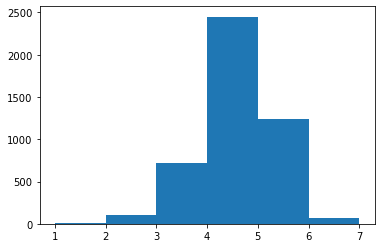

In [48]:
bins = range(1, 8)
plt.hist(iters, bins=bins)
plt.show()

In [49]:
iters = simulate(T, W, [8, 5, 3, 2], 743)

Result 0: 7    acc: 7.0
Result 1: 7    acc: 7.0
Result 2: 7    acc: 7.0
Result 3: 7    acc: 7.0
Result 4: 7    acc: 7.0
Result 5: 7    acc: 7.0
Result 6: 7    acc: 7.0
Result 7: 7    acc: 7.0
Result 8: 7    acc: 7.0
Result 9: 7    acc: 7.0
Result 10: 7    acc: 7.0
Result 11: 6    acc: 6.916666666666667
Result 12: 6    acc: 6.846153846153846
Result 13: 6    acc: 6.785714285714286
Result 14: 1    acc: 6.4
Result 15: 1    acc: 6.0625
Result 16: 1    acc: 5.764705882352941
Result 17: 1    acc: 5.5
Result 18: 1    acc: 5.2631578947368425
Result 19: 5    acc: 5.25
Result 20: 5    acc: 5.238095238095238
Result 21: 6    acc: 5.2727272727272725
Result 22: 6    acc: 5.304347826086956
Result 23: 6    acc: 5.333333333333333
Result 24: 1    acc: 5.16
Result 25: 7    acc: 5.230769230769231
Result 26: 7    acc: 5.296296296296297
Result 27: 7    acc: 5.357142857142857
Result 28: 5    acc: 5.344827586206897
Result 29: 8    acc: 5.433333333333334
Result 30: 8    acc: 5.516129032258065
Result 31: 5    ac

Result 220: 7    acc: 6.276018099547511
Result 221: 5    acc: 6.27027027027027
Result 222: 5    acc: 6.26457399103139
Result 223: 5    acc: 6.258928571428571
Result 224: 7    acc: 6.262222222222222
Result 225: 7    acc: 6.265486725663717
Result 226: 10    acc: 6.28193832599119
Result 227: 8    acc: 6.2894736842105265
Result 228: 8    acc: 6.296943231441048
Result 229: 7    acc: 6.3
Result 230: 7    acc: 6.303030303030303
Result 231: 7    acc: 6.306034482758621
Result 232: 6    acc: 6.304721030042918
Result 233: 5    acc: 6.299145299145299
Result 234: 5    acc: 6.293617021276596
Result 235: 6    acc: 6.2923728813559325
Result 236: 5    acc: 6.286919831223629
Result 237: 5    acc: 6.281512605042017
Result 238: 3    acc: 6.2677824267782425
Result 239: 6    acc: 6.266666666666667
Result 240: 4    acc: 6.257261410788382
Result 241: 5    acc: 6.25206611570248
Result 242: 3    acc: 6.238683127572016
Result 243: 6    acc: 6.237704918032787
Result 244: 6    acc: 6.236734693877551
Result 245: 7 

Result 428: 3    acc: 5.671328671328672
Result 429: 5    acc: 5.669767441860465
Result 430: 5    acc: 5.6682134570765665
Result 431: 8    acc: 5.673611111111111
Result 432: 6    acc: 5.674364896073903
Result 433: 6    acc: 5.675115207373272
Result 434: 3    acc: 5.6689655172413795
Result 435: 6    acc: 5.669724770642202
Result 436: 7    acc: 5.672768878718536
Result 437: 7    acc: 5.675799086757991
Result 438: 6    acc: 5.676537585421412
Result 439: 5    acc: 5.675
Result 440: 5    acc: 5.673469387755102
Result 441: 7    acc: 5.676470588235294
Result 442: 5    acc: 5.6749435665914225
Result 443: 8    acc: 5.68018018018018
Result 444: 6    acc: 5.680898876404495
Result 445: 7    acc: 5.683856502242152
Result 446: 6    acc: 5.684563758389261
Result 447: 4    acc: 5.680803571428571
Result 448: 4    acc: 5.67706013363029
Result 449: 4    acc: 5.673333333333333
Result 450: 4    acc: 5.669623059866963
Result 451: 4    acc: 5.665929203539823
Result 452: 4    acc: 5.662251655629139
Result 453:

Result 637: 5    acc: 5.768025078369906
Result 638: 5    acc: 5.766823161189358
Result 639: 3    acc: 5.7625
Result 640: 3    acc: 5.758190327613105
Result 641: 3    acc: 5.753894080996885
Result 642: 3    acc: 5.749611197511664
Result 643: 3    acc: 5.745341614906832
Result 644: 5    acc: 5.744186046511628
Result 645: 5    acc: 5.743034055727554
Result 646: 5    acc: 5.741885625965997
Result 647: 7    acc: 5.743827160493828
Result 648: 3    acc: 5.73959938366718
Result 649: 3    acc: 5.735384615384615
Result 650: 3    acc: 5.731182795698925
Result 651: 6    acc: 5.7315950920245395
Result 652: 8    acc: 5.735068912710567
Result 653: 3    acc: 5.730886850152905
Result 654: 4    acc: 5.72824427480916
Result 655: 3    acc: 5.724085365853658
Result 656: 8    acc: 5.7275494672754945
Result 657: 8    acc: 5.731003039513678
Result 658: 4    acc: 5.728376327769348
Result 659: 4    acc: 5.725757575757576
Result 660: 4    acc: 5.723146747352496
Result 661: 4    acc: 5.720543806646526
Result 662:

Result 843: 8    acc: 5.649289099526066
Result 844: 8    acc: 5.6520710059171595
Result 845: 8    acc: 5.6548463356974
Result 846: 8    acc: 5.657615112160567
Result 847: 7    acc: 5.659198113207547
Result 848: 5    acc: 5.658421672555948
Result 849: 8    acc: 5.661176470588235
Result 850: 8    acc: 5.663924794359577
Result 851: 8    acc: 5.666666666666667
Result 852: 7    acc: 5.668229777256741
Result 853: 8    acc: 5.67096018735363
Result 854: 7    acc: 5.6725146198830405
Result 855: 5    acc: 5.671728971962617
Result 856: 5    acc: 5.670945157526254
Result 857: 5    acc: 5.67016317016317
Result 858: 5    acc: 5.669383003492433
Result 859: 5    acc: 5.6686046511627906
Result 860: 5    acc: 5.667828106852497
Result 861: 5    acc: 5.667053364269141
Result 862: 5    acc: 5.666280417149479
Result 863: 5    acc: 5.6655092592592595
Result 864: 5    acc: 5.664739884393064
Result 865: 5    acc: 5.6639722863741335
Result 866: 7    acc: 5.665513264129181
Result 867: 6    acc: 5.665898617511520

Result 1048: 5    acc: 5.555767397521449
Result 1049: 5    acc: 5.555238095238095
Result 1050: 5    acc: 5.554709800190295
Result 1051: 5    acc: 5.554182509505703
Result 1052: 5    acc: 5.553656220322887
Result 1053: 5    acc: 5.553130929791271
Result 1054: 5    acc: 5.55260663507109
Result 1055: 3    acc: 5.550189393939394
Result 1056: 5    acc: 5.549668874172186
Result 1057: 5    acc: 5.549149338374291
Result 1058: 5    acc: 5.548630783758263
Result 1059: 5    acc: 5.5481132075471695
Result 1060: 5    acc: 5.547596606974552
Result 1061: 5    acc: 5.547080979284369
Result 1062: 8    acc: 5.549388523047978
Result 1063: 5    acc: 5.548872180451128
Result 1064: 3    acc: 5.546478873239437
Result 1065: 7    acc: 5.547842401500938
Result 1066: 5    acc: 5.547328959700094
Result 1067: 5    acc: 5.546816479400749
Result 1068: 7    acc: 5.5481758652946676
Result 1069: 6    acc: 5.548598130841121
Result 1070: 5    acc: 5.548085901027077
Result 1071: 5    acc: 5.547574626865671
Result 1072: 5 

Result 1249: 8    acc: 5.5336
Result 1250: 8    acc: 5.535571542765787
Result 1251: 6    acc: 5.535942492012779
Result 1252: 6    acc: 5.5363128491620115
Result 1253: 6    acc: 5.536682615629984
Result 1254: 6    acc: 5.537051792828685
Result 1255: 5    acc: 5.536624203821656
Result 1256: 5    acc: 5.536197295147176
Result 1257: 5    acc: 5.53577106518283
Result 1258: 5    acc: 5.535345512311358
Result 1259: 5    acc: 5.534920634920635
Result 1260: 5    acc: 5.534496431403648
Result 1261: 5    acc: 5.5340729001584785
Result 1262: 5    acc: 5.533650039588282
Result 1263: 7    acc: 5.534810126582278
Result 1264: 7    acc: 5.53596837944664
Result 1265: 7    acc: 5.5371248025276465
Result 1266: 7    acc: 5.538279400157853
Result 1267: 7    acc: 5.539432176656152
Result 1268: 7    acc: 5.540583136327817
Result 1269: 8    acc: 5.54251968503937
Result 1270: 8    acc: 5.544453186467349
Result 1271: 6    acc: 5.544811320754717
Result 1272: 6    acc: 5.545168892380204
Result 1273: 6    acc: 5.54

Result 1452: 5    acc: 5.54783207157605
Result 1453: 5    acc: 5.547455295735901
Result 1454: 5    acc: 5.547079037800687
Result 1455: 5    acc: 5.5467032967032965
Result 1456: 5    acc: 5.546328071379547
Result 1457: 5    acc: 5.545953360768175
Result 1458: 6    acc: 5.54626456477039
Result 1459: 5    acc: 5.545890410958904
Result 1460: 6    acc: 5.546201232032854
Result 1461: 6    acc: 5.546511627906977
Result 1462: 6    acc: 5.546821599453178
Result 1463: 5    acc: 5.546448087431694
Result 1464: 5    acc: 5.546075085324232
Result 1465: 5    acc: 5.545702592087312
Result 1466: 5    acc: 5.5453306066803
Result 1467: 5    acc: 5.544959128065395
Result 1468: 5    acc: 5.544588155207625
Result 1469: 6    acc: 5.544897959183674
Result 1470: 6    acc: 5.545207341944256
Result 1471: 6    acc: 5.545516304347826
Result 1472: 6    acc: 5.545824847250509
Result 1473: 5    acc: 5.545454545454546
Result 1474: 5    acc: 5.545084745762712
Result 1475: 5    acc: 5.544715447154472
Result 1476: 8    a

Result 1653: 8    acc: 5.541717049576784
Result 1654: 7    acc: 5.542598187311178
Result 1655: 7    acc: 5.543478260869565
Result 1656: 7    acc: 5.544357272178636
Result 1657: 7    acc: 5.545235223160434
Result 1658: 7    acc: 5.5461121157323685
Result 1659: 7    acc: 5.546987951807229
Result 1660: 7    acc: 5.547862733293197
Result 1661: 7    acc: 5.548736462093863
Result 1662: 8    acc: 5.550210463018641
Result 1663: 7    acc: 5.551081730769231
Result 1664: 7    acc: 5.551951951951952
Result 1665: 7    acc: 5.552821128451381
Result 1666: 7    acc: 5.553689262147571
Result 1667: 7    acc: 5.554556354916067
Result 1668: 7    acc: 5.555422408627921
Result 1669: 7    acc: 5.5562874251497005
Result 1670: 7    acc: 5.557151406343507
Result 1671: 7    acc: 5.5580143540669855
Result 1672: 6    acc: 5.55827854154214
Result 1673: 6    acc: 5.558542413381123
Result 1674: 6    acc: 5.558805970149254
Result 1675: 5    acc: 5.558472553699284
Result 1676: 6    acc: 5.558735837805605
Result 1677: 6

Result 1853: 6    acc: 5.59277238403452
Result 1854: 8    acc: 5.594070080862534
Result 1855: 7    acc: 5.594827586206897
Result 1856: 5    acc: 5.594507269789984
Result 1857: 6    acc: 5.594725511302475
Result 1858: 5    acc: 5.594405594405594
Result 1859: 5    acc: 5.594086021505376
Result 1860: 5    acc: 5.593766792047286
Result 1861: 5    acc: 5.593447905477981
Result 1862: 7    acc: 5.594202898550725
Result 1863: 8    acc: 5.59549356223176
Result 1864: 6    acc: 5.595710455764075
Result 1865: 5    acc: 5.595391211146838
Result 1866: 7    acc: 5.596143545795393
Result 1867: 6    acc: 5.5963597430406855
Result 1868: 7    acc: 5.597110754414126
Result 1869: 5    acc: 5.596791443850267
Result 1870: 5    acc: 5.596472474612507
Result 1871: 6    acc: 5.596688034188034
Result 1872: 6    acc: 5.596903363587827
Result 1873: 6    acc: 5.5971184631803625
Result 1874: 6    acc: 5.597333333333333
Result 1875: 6    acc: 5.597547974413646
Result 1876: 6    acc: 5.597762386787426
Result 1877: 4  

Result 2054: 5    acc: 5.62676399026764
Result 2055: 5    acc: 5.626459143968872
Result 2056: 7    acc: 5.627126883811376
Result 2057: 5    acc: 5.626822157434402
Result 2058: 5    acc: 5.626517727051967
Result 2059: 5    acc: 5.62621359223301
Result 2060: 5    acc: 5.625909752547307
Result 2061: 6    acc: 5.626091173617847
Result 2062: 6    acc: 5.626272418807562
Result 2063: 6    acc: 5.626453488372093
Result 2064: 6    acc: 5.626634382566586
Result 2065: 6    acc: 5.626815101645692
Result 2066: 6    acc: 5.626995645863571
Result 2067: 6    acc: 5.6271760154738875
Result 2068: 9    acc: 5.6288061865635575
Result 2069: 9    acc: 5.630434782608695
Result 2070: 4    acc: 5.629647513278609
Result 2071: 4    acc: 5.628861003861004
Result 2072: 4    acc: 5.62807525325615
Result 2073: 6    acc: 5.628254580520733
Result 2074: 6    acc: 5.628433734939759
Result 2075: 6    acc: 5.628612716763006
Result 2076: 6    acc: 5.628791526239769
Result 2077: 5    acc: 5.628488931665062
Result 2078: 8   

Result 2255: 6    acc: 5.530141843971631
Result 2256: 6    acc: 5.530350022153301
Result 2257: 5    acc: 5.530115146147033
Result 2258: 6    acc: 5.530323151837096
Result 2259: 5    acc: 5.530088495575221
Result 2260: 5    acc: 5.529854046881911
Result 2261: 6    acc: 5.530061892130858
Result 2262: 5    acc: 5.529827662395051
Result 2263: 6    acc: 5.530035335689046
Result 2264: 6    acc: 5.530242825607064
Result 2265: 6    acc: 5.53045013239188
Result 2266: 6    acc: 5.53065725628584
Result 2267: 6    acc: 5.530864197530864
Result 2268: 5    acc: 5.530630233583076
Result 2269: 6    acc: 5.530837004405286
Result 2270: 6    acc: 5.5310435931307795
Result 2271: 7    acc: 5.53169014084507
Result 2272: 7    acc: 5.53233611966564
Result 2273: 7    acc: 5.532981530343008
Result 2274: 7    acc: 5.533626373626373
Result 2275: 6    acc: 5.533831282952549
Result 2276: 7    acc: 5.534475186649099
Result 2277: 6    acc: 5.534679543459175
Result 2278: 7    acc: 5.535322509872751
Result 2279: 6    a

Result 2456: 3    acc: 5.499389499389499
Result 2457: 3    acc: 5.498372660699756
Result 2458: 3    acc: 5.497356649044327
Result 2459: 3    acc: 5.496341463414634
Result 2460: 4    acc: 5.49573344169037
Result 2461: 3    acc: 5.49471974004874
Result 2462: 3    acc: 5.493706861550955
Result 2463: 3    acc: 5.492694805194805
Result 2464: 3    acc: 5.491683569979716
Result 2465: 3    acc: 5.490673154906731
Result 2466: 3    acc: 5.489663558978516
Result 2467: 3    acc: 5.488654781199352
Result 2468: 3    acc: 5.487646820575131
Result 2469: 3    acc: 5.48663967611336
Result 2470: 3    acc: 5.485633346823149
Result 2471: 3    acc: 5.48462783171521
Result 2472: 3    acc: 5.4836231298018605
Result 2473: 3    acc: 5.482619240097009
Result 2474: 3    acc: 5.481616161616162
Result 2475: 3    acc: 5.480613893376414
Result 2476: 3    acc: 5.479612434396447
Result 2477: 3    acc: 5.47861178369653
Result 2478: 6    acc: 5.478822105687778
Result 2479: 3    acc: 5.477822580645161
Result 2480: 3    ac

Result 2657: 6    acc: 5.4100827689992474
Result 2658: 6    acc: 5.4103046257991725
Result 2659: 6    acc: 5.410526315789474
Result 2660: 6    acc: 5.410747839158211
Result 2661: 6    acc: 5.410969196093163
Result 2662: 5    acc: 5.410814870446864
Result 2663: 5    acc: 5.41066066066066
Result 2664: 6    acc: 5.410881801125703
Result 2665: 6    acc: 5.411102775693924
Result 2666: 6    acc: 5.411323584551931
Result 2667: 6    acc: 5.411544227886057
Result 2668: 6    acc: 5.411764705882353
Result 2669: 4    acc: 5.4112359550561795
Result 2670: 6    acc: 5.411456383377012
Result 2671: 4    acc: 5.4109281437125745
Result 2672: 6    acc: 5.411148522259634
Result 2673: 6    acc: 5.411368735976065
Result 2674: 5    acc: 5.411214953271028
Result 2675: 5    acc: 5.411061285500748
Result 2676: 7    acc: 5.41165483750467
Result 2677: 8    acc: 5.412621359223301
Result 2678: 10    acc: 5.414333706606943
Result 2679: 9    acc: 5.415671641791045
Result 2680: 6    acc: 5.415889593435286
Result 2681: 

Result 2859: 5    acc: 5.424825174825175
Result 2860: 5    acc: 5.424676686473261
Result 2861: 5    acc: 5.4245283018867925
Result 2862: 5    acc: 5.424380020957038
Result 2863: 5    acc: 5.424231843575419
Result 2864: 5    acc: 5.424083769633508
Result 2865: 5    acc: 5.423935799023028
Result 2866: 5    acc: 5.423787931635856
Result 2867: 4    acc: 5.423291492329149
Result 2868: 6    acc: 5.423492506099686
Result 2869: 6    acc: 5.423693379790941
Result 2870: 4    acc: 5.423197492163009
Result 2871: 6    acc: 5.423398328690808
Result 2872: 6    acc: 5.42359902540898
Result 2873: 6    acc: 5.423799582463466
Result 2874: 6    acc: 5.424
Result 2875: 5    acc: 5.423852573018081
Result 2876: 5    acc: 5.423705248522767
Result 2877: 5    acc: 5.423558026407227
Result 2878: 5    acc: 5.423410906564779
Result 2879: 5    acc: 5.423263888888889
Result 2880: 5    acc: 5.423116973273169
Result 2881: 5    acc: 5.422970159611381
Result 2882: 5    acc: 5.422823447797433
Result 2883: 4    acc: 5.422

Result 3060: 6    acc: 5.3508657301535445
Result 3061: 6    acc: 5.3510777269758325
Result 3062: 5    acc: 5.35096310806399
Result 3063: 5    acc: 5.350848563968668
Result 3064: 6    acc: 5.3510603588907015
Result 3065: 6    acc: 5.351272015655577
Result 3066: 6    acc: 5.351483534398435
Result 3067: 6    acc: 5.351694915254237
Result 3068: 6    acc: 5.351906158357771
Result 3069: 5    acc: 5.351791530944626
Result 3070: 5    acc: 5.3516769781830025
Result 3071: 5    acc: 5.3515625
Result 3072: 5    acc: 5.3514480963228115
Result 3073: 5    acc: 5.351333767078724
Result 3074: 5    acc: 5.351219512195122
Result 3075: 5    acc: 5.35110533159948
Result 3076: 5    acc: 5.35099122521937
Result 3077: 6    acc: 5.351202079272254
Result 3078: 6    acc: 5.351412796362455
Result 3079: 6    acc: 5.351623376623377
Result 3080: 6    acc: 5.351833820188251
Result 3081: 6    acc: 5.352044127190136
Result 3082: 6    acc: 5.35225429776192
Result 3083: 6    acc: 5.352464332036316
Result 3084: 6    acc: 

Result 3261: 6    acc: 5.385959534028204
Result 3262: 6    acc: 5.386147716825008
Result 3263: 4    acc: 5.385723039215686
Result 3264: 4    acc: 5.385298621745789
Result 3265: 4    acc: 5.384874464176362
Result 3266: 4    acc: 5.3844505662687485
Result 3267: 5    acc: 5.384332925336597
Result 3268: 5    acc: 5.384215356378097
Result 3269: 4    acc: 5.383792048929664
Result 3270: 3    acc: 5.383063283399572
Result 3271: 3    acc: 5.382334963325183
Result 3272: 3    acc: 5.381607088298197
Result 3273: 7    acc: 5.382101405009163
Result 3274: 5    acc: 5.381984732824428
Result 3275: 4    acc: 5.381562881562882
Result 3276: 6    acc: 5.381751602075068
Result 3277: 6    acc: 5.381940207443563
Result 3278: 4    acc: 5.381518755718207
Result 3279: 6    acc: 5.381707317073171
Result 3280: 5    acc: 5.381590978360256
Result 3281: 6    acc: 5.3817794028031685
Result 3282: 5    acc: 5.381663113006397
Result 3283: 5    acc: 5.381546894031668
Result 3284: 5    acc: 5.381430745814307
Result 3285: 5

Result 3461: 6    acc: 5.391681109185442
Result 3462: 6    acc: 5.3918567715853305
Result 3463: 6    acc: 5.39203233256351
Result 3464: 7    acc: 5.392496392496392
Result 3465: 7    acc: 5.392960184650894
Result 3466: 7    acc: 5.393423709258725
Result 3467: 7    acc: 5.393886966551326
Result 3468: 7    acc: 5.394349956759873
Result 3469: 8    acc: 5.3951008645533145
Result 3470: 8    acc: 5.395851339671564
Result 3471: 7    acc: 5.3963133640553
Result 3472: 7    acc: 5.396775122372588
Result 3473: 6    acc: 5.396948762233737
Result 3474: 6    acc: 5.397122302158273
Result 3475: 6    acc: 5.397295742232451
Result 3476: 7    acc: 5.397756686798965
Result 3477: 9    acc: 5.398792409430707
Result 3478: 10    acc: 5.400114975567692
Result 3479: 10    acc: 5.4014367816091955
Result 3480: 8    acc: 5.402183280666475
Result 3481: 8    acc: 5.402929350947731
Result 3482: 9    acc: 5.4039621016365205
Result 3483: 9    acc: 5.404994259471872
Result 3484: 6    acc: 5.405164992826399
Result 3485: 

Result 3661: 6    acc: 5.417258328782086
Result 3662: 7    acc: 5.417690417690418
Result 3663: 7    acc: 5.418122270742358
Result 3664: 7    acc: 5.418553888130969
Result 3665: 8    acc: 5.419258046917621
Result 3666: 4    acc: 5.418871011726207
Result 3667: 6    acc: 5.419029443838604
Result 3668: 6    acc: 5.4191877895884435
Result 3669: 6    acc: 5.419346049046322
Result 3670: 6    acc: 5.4195042222827565
Result 3671: 6    acc: 5.419662309368192
Result 3672: 5    acc: 5.419548053362374
Result 3673: 5    acc: 5.41943385955362
Result 3674: 6    acc: 5.419591836734694
Result 3675: 6    acc: 5.419749727965179
Result 3676: 6    acc: 5.419907533315203
Result 3677: 6    acc: 5.420065252854813
Result 3678: 4    acc: 5.41967926066866
Result 3679: 4    acc: 5.41929347826087
Result 3680: 6    acc: 5.419451236077153
Result 3681: 5    acc: 5.41933731667572
Result 3682: 5    acc: 5.419223459136574
Result 3683: 5    acc: 5.419109663409338
Result 3684: 5    acc: 5.418995929443691
Result 3685: 6    

Result 3861: 6    acc: 5.408596582081823
Result 3862: 6    acc: 5.408749676417292
Result 3863: 6    acc: 5.408902691511387
Result 3864: 6    acc: 5.409055627425614
Result 3865: 6    acc: 5.409208484221417
Result 3866: 5    acc: 5.409102663563486
Result 3867: 6    acc: 5.409255429162358
Result 3868: 6    acc: 5.4094081157921945
Result 3869: 6    acc: 5.409560723514212
Result 3870: 6    acc: 5.4097132523895635
Result 3871: 6    acc: 5.409865702479339
Result 3872: 6    acc: 5.410018073844565
Result 3873: 5    acc: 5.409912235415591
Result 3874: 4    acc: 5.409548387096774
Result 3875: 4    acc: 5.409184726522188
Result 3876: 6    acc: 5.409337116327057
Result 3877: 6    acc: 5.409489427539969
Result 3878: 5    acc: 5.409383861820057
Result 3879: 4    acc: 5.409020618556701
Result 3880: 5    acc: 5.408915228034012
Result 3881: 6    acc: 5.409067490984029
Result 3882: 6    acc: 5.409219675508627
Result 3883: 6    acc: 5.4093717816683835
Result 3884: 7    acc: 5.40978120978121
Result 3885: 7

Result 4063: 6    acc: 5.428149606299213
Result 4064: 6    acc: 5.428290282902829
Result 4065: 6    acc: 5.428430890309887
Result 4066: 6    acc: 5.428571428571429
Result 4067: 6    acc: 5.428711897738446
Result 4068: 6    acc: 5.428852297861883
Result 4069: 6    acc: 5.428992628992629
Result 4070: 7    acc: 5.429378531073446
Result 4071: 7    acc: 5.429764243614931
Result 4072: 4    acc: 5.429413208936902
Result 4073: 4    acc: 5.42906234658812
Result 4074: 6    acc: 5.42920245398773
Result 4075: 6    acc: 5.429342492639843
Result 4076: 5    acc: 5.429237184204071
Result 4077: 6    acc: 5.429377145659637
Result 4078: 6    acc: 5.429517038489826
Result 4079: 6    acc: 5.429656862745098
Result 4080: 5    acc: 5.4295515804949765
Result 4081: 6    acc: 5.4296913277805
Result 4082: 6    acc: 5.429831006612785
Result 4083: 5    acc: 5.429725759059745
Result 4084: 5    acc: 5.4296205630354955
Result 4085: 6    acc: 5.429760156632403
Result 4086: 5    acc: 5.429655003670174
Result 4087: 5    

Result 4265: 6    acc: 5.447257383966245
Result 4266: 6    acc: 5.447386922896649
Result 4267: 5    acc: 5.447282099343955
Result 4268: 5    acc: 5.447177324900445
Result 4269: 6    acc: 5.447306791569087
Result 4270: 6    acc: 5.4474361976118
Result 4271: 6    acc: 5.447565543071161
Result 4272: 6    acc: 5.447694827989703
Result 4273: 6    acc: 5.447824052409921
Result 4274: 6    acc: 5.447953216374269
Result 4275: 6    acc: 5.448082319925164
Result 4276: 6    acc: 5.44821136310498
Result 4277: 6    acc: 5.448340345956054
Result 4278: 6    acc: 5.448469268520682
Result 4279: 6    acc: 5.4485981308411215
Result 4280: 6    acc: 5.448726932959589
Result 4281: 7    acc: 5.4490892106492295
Result 4282: 7    acc: 5.449451319168807
Result 4283: 7    acc: 5.449813258636788
Result 4284: 6    acc: 5.449941656942824
Result 4285: 6    acc: 5.450069995333644
Result 4286: 8    acc: 5.450664800559832
Result 4287: 8    acc: 5.451259328358209
Result 4288: 8    acc: 5.451853578922826
Result 4289: 8   

Result 4466: 5    acc: 5.4611596149541075
Result 4467: 5    acc: 5.461056401074306
Result 4468: 8    acc: 5.461624524502126
Result 4469: 7    acc: 5.461968680089486
Result 4470: 5    acc: 5.461865354506822
Result 4471: 5    acc: 5.4617620751341684
Result 4472: 9    acc: 5.462553096355913
Result 4473: 9    acc: 5.463343763969602
Result 4474: 8    acc: 5.4639106145251395
Result 4475: 6    acc: 5.4640303842716715
Result 4476: 3    acc: 5.463480008934554
Result 4477: 6    acc: 5.463599821348817
Result 4478: 5    acc: 5.463496316141996
Result 4479: 8    acc: 5.4640625
Result 4480: 6    acc: 5.464182102209328
Result 4481: 7    acc: 5.464524765729585
Result 4482: 6    acc: 5.4646442114655365
Result 4483: 7    acc: 5.464986619090098
Result 4484: 6    acc: 5.465105908584169
Result 4485: 6    acc: 5.465225144895229
Result 4486: 8    acc: 5.465790060173836
Result 4487: 7    acc: 5.466131907308378
Result 4488: 5    acc: 5.466028068612163
Result 4489: 7    acc: 5.466369710467706
Result 4490: 6    a

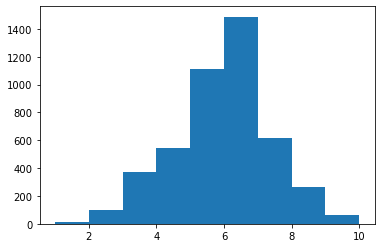

In [55]:
bins = range(1, max(iters) + 1)
plt.hist(iters, bins=bins)
plt.show()

## Simulación usando algoritmo glotón

In [6]:
# Primero se obtiene solución común a primera separación (para no caclularla en cada simulación)

low = 0; high = N
while low != high:
    mid = (low + high) // 2
    P, sP = greedyAppReduceDynamic(G, W, [0] * N, 8, mid, 1e8)
    if N - sP < mid:
        high = mid
    else:
        low = mid + 1
init_P, _ = greedyAppReduceDynamic(G, W, [0] * N, 8, low - 1, 1e8)

In [21]:

iters = []  # Lista que guarda cantidad de iteraciones usadas en encontrar cada nodo

for r in range(N): # Para cada nodo simulamos
    
    # Se marcan los nodos donde sería detectable COVID propagando según el grafo
    
    CV = [0 for u in range(N)]

    CV[r] = 1
    Q = deque([]); Q.append(r)
    while Q:
        u = Q.popleft()
        for v in G.successors(u):
            if not CV[v]:
                CV[v] = 1
                Q.append(v)
                
    # Inicio de simulación

    V = [0] * N  # 1: nodos descartados en la búsqueda, 0: potenciales

    R = N; s = 743
    for t in range(100):
        
        # Primero se obtiene la muestra usando el algoritmo glotón
        
        R = sum([1 - V[u] for u in range(N)]); P = []; sP = 0
        if t == 0:
            P = init_P
        elif R >= 10:
            low = 0; high = R
            while low != high:
                mid = (low + high) // 2
                P, sP = greedyAppReduceDynamic(G, W, V, 5, mid, 1e8)
                if R - sP < mid:
                    high = mid
                else:
                    low = mid + 1
            P, sP = greedyAppReduceDynamic(G, W, V, 5, low, 1e8)
            if low > 1:
                P_, sP_ = greedyAppReduceDynamic(G, W, V, 5, low - 1, 1e8)
                if abs(sP_ - (low - 1)) < abs(sP - low):
                    P = P_; sP = sP_
        else:
            P, sP = greedyAppReduceDynamic(G, W, V, 5, 1, 1e8)
            
        if s not in P:
            P.append(s)
        
        P = find_order(G, V, P, s)
        
        # Descartamos nodos según resultados en cada muestra
        
        for u in P[::-1]:
            if CV[u]:
                I = set(get_ideal(G, V, u)[::-1])
                V = [not (v in I) for v in range(N)]
                s = u; break
            else:
                V, _ = visit(G, V, u)
                
        # Verificamos condición de término

        size, weight = get_size_weight(G, W, V, s)

        if size == 1 or weight <= 200:
            iters.append(t + 1)
            print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / (r + 1)}")
            break
        if t == 99:
            iters.append(100)
            print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / (r + 1)}")
            
print(sum(iters) / len(iters), max(iters))

Result 0: 4    acc: 4.0
Result 1: 5    acc: 4.5
Result 2: 4    acc: 4.333333333333333
Result 3: 5    acc: 4.5
Result 4: 5    acc: 4.6
Result 5: 4    acc: 4.5
Result 6: 4    acc: 4.428571428571429
Result 7: 4    acc: 4.375
Result 8: 4    acc: 4.333333333333333
Result 9: 4    acc: 4.3
Result 10: 4    acc: 4.2727272727272725
Result 11: 4    acc: 4.25
Result 12: 4    acc: 4.230769230769231
Result 13: 4    acc: 4.214285714285714
Result 14: 1    acc: 4.0
Result 15: 1    acc: 3.8125
Result 16: 1    acc: 3.6470588235294117
Result 17: 4    acc: 3.6666666666666665
Result 18: 1    acc: 3.526315789473684
Result 19: 4    acc: 3.55
Result 20: 4    acc: 3.5714285714285716
Result 21: 4    acc: 3.590909090909091
Result 22: 4    acc: 3.608695652173913
Result 23: 4    acc: 3.625
Result 24: 4    acc: 3.64
Result 25: 4    acc: 3.6538461538461537
Result 26: 5    acc: 3.7037037037037037
Result 27: 4    acc: 3.7142857142857144
Result 28: 5    acc: 3.7586206896551726
Result 29: 6    acc: 3.8333333333333335
Res

Result 217: 4    acc: 4.151376146788991
Result 218: 5    acc: 4.155251141552512
Result 219: 5    acc: 4.159090909090909
Result 220: 3    acc: 4.153846153846154
Result 221: 3    acc: 4.148648648648648
Result 222: 4    acc: 4.147982062780269
Result 223: 4    acc: 4.147321428571429
Result 224: 4    acc: 4.1466666666666665
Result 225: 4    acc: 4.146017699115045
Result 226: 5    acc: 4.149779735682819
Result 227: 5    acc: 4.1535087719298245
Result 228: 4    acc: 4.152838427947598
Result 229: 4    acc: 4.1521739130434785
Result 230: 4    acc: 4.151515151515151
Result 231: 4    acc: 4.150862068965517
Result 232: 4    acc: 4.150214592274678
Result 233: 4    acc: 4.14957264957265
Result 234: 4    acc: 4.148936170212766
Result 235: 4    acc: 4.148305084745763
Result 236: 4    acc: 4.147679324894515
Result 237: 4    acc: 4.147058823529412
Result 238: 4    acc: 4.146443514644352
Result 239: 4    acc: 4.145833333333333
Result 240: 3    acc: 4.141078838174274
Result 241: 5    acc: 4.14462809917355

Result 424: 4    acc: 4.176470588235294
Result 425: 4    acc: 4.176056338028169
Result 426: 4    acc: 4.1756440281030445
Result 427: 4    acc: 4.175233644859813
Result 428: 4    acc: 4.174825174825175
Result 429: 4    acc: 4.174418604651163
Result 430: 4    acc: 4.174013921113689
Result 431: 5    acc: 4.175925925925926
Result 432: 4    acc: 4.175519630484988
Result 433: 4    acc: 4.175115207373272
Result 434: 5    acc: 4.1770114942528735
Result 435: 4    acc: 4.176605504587156
Result 436: 4    acc: 4.176201372997712
Result 437: 4    acc: 4.175799086757991
Result 438: 4    acc: 4.175398633257403
Result 439: 4    acc: 4.175
Result 440: 4    acc: 4.174603174603175
Result 441: 4    acc: 4.17420814479638
Result 442: 4    acc: 4.173814898419865
Result 443: 4    acc: 4.173423423423423
Result 444: 4    acc: 4.1730337078651685
Result 445: 4    acc: 4.172645739910314
Result 446: 5    acc: 4.174496644295302
Result 447: 4    acc: 4.174107142857143
Result 448: 4    acc: 4.173719376391982
Result 449

Result 631: 4    acc: 4.1534810126582276
Result 632: 6    acc: 4.156398104265403
Result 633: 6    acc: 4.159305993690852
Result 634: 6    acc: 4.162204724409449
Result 635: 6    acc: 4.165094339622642
Result 636: 6    acc: 4.167974882260596
Result 637: 6    acc: 4.170846394984326
Result 638: 6    acc: 4.173708920187793
Result 639: 3    acc: 4.171875
Result 640: 3    acc: 4.170046801872075
Result 641: 3    acc: 4.168224299065421
Result 642: 3    acc: 4.166407465007776
Result 643: 3    acc: 4.1645962732919255
Result 644: 4    acc: 4.164341085271317
Result 645: 4    acc: 4.164086687306502
Result 646: 4    acc: 4.163833075734158
Result 647: 4    acc: 4.16358024691358
Result 648: 3    acc: 4.1617873651771955
Result 649: 4    acc: 4.161538461538462
Result 650: 4    acc: 4.161290322580645
Result 651: 4    acc: 4.161042944785276
Result 652: 6    acc: 4.16385911179173
Result 653: 3    acc: 4.162079510703364
Result 654: 4    acc: 4.1618320610687025
Result 655: 4    acc: 4.161585365853658
Result 

Result 837: 3    acc: 4.173031026252984
Result 838: 4    acc: 4.172824791418355
Result 839: 4    acc: 4.1726190476190474
Result 840: 4    acc: 4.172413793103448
Result 841: 4    acc: 4.172209026128266
Result 842: 4    acc: 4.172004744958482
Result 843: 4    acc: 4.171800947867299
Result 844: 4    acc: 4.171597633136095
Result 845: 5    acc: 4.1725768321513
Result 846: 5    acc: 4.1735537190082646
Result 847: 5    acc: 4.1745283018867925
Result 848: 5    acc: 4.175500588928151
Result 849: 5    acc: 4.176470588235294
Result 850: 4    acc: 4.176263219741481
Result 851: 4    acc: 4.176056338028169
Result 852: 3    acc: 4.174677608440797
Result 853: 5    acc: 4.1756440281030445
Result 854: 4    acc: 4.175438596491228
Result 855: 4    acc: 4.175233644859813
Result 856: 4    acc: 4.175029171528588
Result 857: 4    acc: 4.174825174825175
Result 858: 4    acc: 4.174621653084983
Result 859: 4    acc: 4.174418604651163
Result 860: 4    acc: 4.174216027874564
Result 861: 4    acc: 4.17401392111368

Result 1042: 5    acc: 4.1553211888782355
Result 1043: 5    acc: 4.156130268199234
Result 1044: 4    acc: 4.155980861244019
Result 1045: 5    acc: 4.15678776290631
Result 1046: 5    acc: 4.157593123209169
Result 1047: 5    acc: 4.158396946564886
Result 1048: 4    acc: 4.158245948522402
Result 1049: 4    acc: 4.158095238095238
Result 1050: 5    acc: 4.158896289248335
Result 1051: 4    acc: 4.158745247148289
Result 1052: 5    acc: 4.15954415954416
Result 1053: 4    acc: 4.159392789373814
Result 1054: 5    acc: 4.160189573459716
Result 1055: 4    acc: 4.160037878787879
Result 1056: 4    acc: 4.159886471144749
Result 1057: 4    acc: 4.159735349716446
Result 1058: 5    acc: 4.160528800755429
Result 1059: 4    acc: 4.160377358490566
Result 1060: 5    acc: 4.161168708765316
Result 1061: 5    acc: 4.16195856873823
Result 1062: 5    acc: 4.1627469426152395
Result 1063: 4    acc: 4.162593984962406
Result 1064: 5    acc: 4.163380281690141
Result 1065: 4    acc: 4.163227016885553
Result 1066: 5   

Result 1242: 5    acc: 4.16331456154465
Result 1243: 4    acc: 4.163183279742765
Result 1244: 5    acc: 4.163855421686747
Result 1245: 5    acc: 4.164526484751204
Result 1246: 5    acc: 4.165196471531676
Result 1247: 5    acc: 4.165865384615385
Result 1248: 4    acc: 4.165732586068855
Result 1249: 4    acc: 4.1656
Result 1250: 4    acc: 4.16546762589928
Result 1251: 4    acc: 4.165335463258786
Result 1252: 4    acc: 4.165203511572226
Result 1253: 4    acc: 4.1650717703349285
Result 1254: 4    acc: 4.164940239043824
Result 1255: 4    acc: 4.164808917197452
Result 1256: 4    acc: 4.164677804295943
Result 1257: 4    acc: 4.164546899841017
Result 1258: 5    acc: 4.165210484511517
Result 1259: 5    acc: 4.165873015873016
Result 1260: 5    acc: 4.166534496431404
Result 1261: 5    acc: 4.167194928684627
Result 1262: 5    acc: 4.167854315122724
Result 1263: 5    acc: 4.168512658227848
Result 1264: 5    acc: 4.169169960474308
Result 1265: 5    acc: 4.169826224328594
Result 1266: 5    acc: 4.170

Result 1443: 4    acc: 4.2202216066482
Result 1444: 4    acc: 4.220069204152249
Result 1445: 4    acc: 4.219917012448133
Result 1446: 5    acc: 4.22045611610228
Result 1447: 3    acc: 4.219613259668508
Result 1448: 4    acc: 4.219461697722568
Result 1449: 4    acc: 4.219310344827586
Result 1450: 4    acc: 4.219159200551344
Result 1451: 4    acc: 4.2190082644628095
Result 1452: 4    acc: 4.21885753613214
Result 1453: 6    acc: 4.220082530949106
Result 1454: 6    acc: 4.221305841924399
Result 1455: 4    acc: 4.221153846153846
Result 1456: 4    acc: 4.221002059025395
Result 1457: 5    acc: 4.221536351165981
Result 1458: 5    acc: 4.222069910897876
Result 1459: 6    acc: 4.223287671232876
Result 1460: 6    acc: 4.224503764544832
Result 1461: 6    acc: 4.225718194254446
Result 1462: 6    acc: 4.226930963773069
Result 1463: 6    acc: 4.228142076502732
Result 1464: 6    acc: 4.2293515358361775
Result 1465: 5    acc: 4.229877216916781
Result 1466: 6    acc: 4.231083844580777
Result 1467: 5    

Result 1644: 4    acc: 4.227355623100304
Result 1645: 4    acc: 4.227217496962333
Result 1646: 4    acc: 4.227079538554948
Result 1647: 4    acc: 4.226941747572815
Result 1648: 4    acc: 4.22680412371134
Result 1649: 4    acc: 4.226666666666667
Result 1650: 4    acc: 4.226529376135676
Result 1651: 4    acc: 4.22639225181598
Result 1652: 4    acc: 4.226255293405929
Result 1653: 4    acc: 4.226118500604595
Result 1654: 4    acc: 4.225981873111783
Result 1655: 4    acc: 4.225845410628019
Result 1656: 4    acc: 4.225709112854556
Result 1657: 4    acc: 4.225572979493365
Result 1658: 4    acc: 4.225437010247137
Result 1659: 4    acc: 4.225301204819277
Result 1660: 4    acc: 4.225165562913907
Result 1661: 4    acc: 4.22503008423586
Result 1662: 4    acc: 4.22489476849068
Result 1663: 4    acc: 4.224759615384615
Result 1664: 4    acc: 4.224624624624624
Result 1665: 4    acc: 4.224489795918367
Result 1666: 4    acc: 4.224355128974205
Result 1667: 4    acc: 4.224220623501199
Result 1668: 4    ac

Result 1844: 4    acc: 4.21409214092141
Result 1845: 5    acc: 4.214517876489707
Result 1846: 4    acc: 4.214401732539253
Result 1847: 4    acc: 4.214285714285714
Result 1848: 3    acc: 4.213628988642509
Result 1849: 4    acc: 4.213513513513513
Result 1850: 4    acc: 4.213398163155051
Result 1851: 4    acc: 4.213282937365011
Result 1852: 5    acc: 4.213707501349163
Result 1853: 4    acc: 4.213592233009709
Result 1854: 5    acc: 4.214016172506739
Result 1855: 5    acc: 4.214439655172414
Result 1856: 5    acc: 4.21486268174475
Result 1857: 4    acc: 4.214747039827772
Result 1858: 5    acc: 4.215169445938677
Result 1859: 4    acc: 4.21505376344086
Result 1860: 5    acc: 4.215475550779151
Result 1861: 5    acc: 4.215896885069817
Result 1862: 5    acc: 4.216317767042405
Result 1863: 5    acc: 4.216738197424893
Result 1864: 4    acc: 4.216621983914209
Result 1865: 5    acc: 4.217041800643087
Result 1866: 4    acc: 4.2169255490091055
Result 1867: 4    acc: 4.216809421841542
Result 1868: 4    

Result 2045: 4    acc: 4.2272727272727275
Result 2046: 4    acc: 4.227161700048852
Result 2047: 4    acc: 4.22705078125
Result 2048: 4    acc: 4.2269399707174236
Result 2049: 4    acc: 4.226829268292683
Result 2050: 4    acc: 4.22671867381765
Result 2051: 4    acc: 4.226608187134503
Result 2052: 5    acc: 4.226984900146127
Result 2053: 4    acc: 4.226874391431354
Result 2054: 4    acc: 4.2267639902676395
Result 2055: 3    acc: 4.226167315175097
Result 2056: 4    acc: 4.226057365094798
Result 2057: 4    acc: 4.225947521865889
Result 2058: 4    acc: 4.225837785332685
Result 2059: 4    acc: 4.225728155339806
Result 2060: 4    acc: 4.225618631732169
Result 2061: 4    acc: 4.225509214354995
Result 2062: 4    acc: 4.225399903053805
Result 2063: 4    acc: 4.225290697674419
Result 2064: 4    acc: 4.225181598062954
Result 2065: 4    acc: 4.2250726040658275
Result 2066: 4    acc: 4.2249637155297535
Result 2067: 4    acc: 4.224854932301741
Result 2068: 4    acc: 4.224746254229096
Result 2069: 6  

Result 2246: 3    acc: 4.1882510013351135
Result 2247: 3    acc: 4.187722419928826
Result 2248: 4    acc: 4.187638950644731
Result 2249: 5    acc: 4.188
Result 2250: 4    acc: 4.187916481563749
Result 2251: 4    acc: 4.1878330373001775
Result 2252: 4    acc: 4.187749667110519
Result 2253: 4    acc: 4.187666370896185
Result 2254: 4    acc: 4.187583148558758
Result 2255: 4    acc: 4.1875
Result 2256: 5    acc: 4.18785999113868
Result 2257: 5    acc: 4.188219663418955
Result 2258: 5    acc: 4.188579017264276
Result 2259: 5    acc: 4.1889380530973455
Result 2260: 5    acc: 4.189296771340115
Result 2261: 5    acc: 4.189655172413793
Result 2262: 5    acc: 4.190013256738842
Result 2263: 4    acc: 4.189929328621908
Result 2264: 4    acc: 4.189845474613686
Result 2265: 4    acc: 4.189761694616063
Result 2266: 4    acc: 4.189677988531098
Result 2267: 4    acc: 4.189594356261023
Result 2268: 4    acc: 4.189510797708241
Result 2269: 4    acc: 4.18942731277533
Result 2270: 4    acc: 4.1893439013650

Result 2447: 4    acc: 4.17687908496732
Result 2448: 4    acc: 4.176806859942833
Result 2449: 3    acc: 4.176326530612245
Result 2450: 4    acc: 4.17625458996328
Result 2451: 4    acc: 4.176182707993474
Result 2452: 4    acc: 4.176110884631064
Result 2453: 4    acc: 4.176039119804401
Result 2454: 4    acc: 4.175967413441955
Result 2455: 4    acc: 4.175895765472313
Result 2456: 4    acc: 4.175824175824176
Result 2457: 4    acc: 4.175752644426363
Result 2458: 4    acc: 4.175681171207808
Result 2459: 4    acc: 4.175609756097561
Result 2460: 5    acc: 4.1759447379114185
Result 2461: 5    acc: 4.176279447603575
Result 2462: 4    acc: 4.176207876573285
Result 2463: 5    acc: 4.176542207792208
Result 2464: 5    acc: 4.1768762677484785
Result 2465: 5    acc: 4.1772100567721
Result 2466: 5    acc: 4.177543575192542
Result 2467: 5    acc: 4.177876823338736
Result 2468: 5    acc: 4.178209801539085
Result 2469: 5    acc: 4.178542510121457
Result 2470: 5    acc: 4.178874949413193
Result 2471: 5    

Result 2648: 4    acc: 4.165345413363533
Result 2649: 4    acc: 4.165283018867925
Result 2650: 4    acc: 4.165220671444738
Result 2651: 4    acc: 4.165158371040724
Result 2652: 4    acc: 4.1650961176027135
Result 2653: 4    acc: 4.165033911077619
Result 2654: 4    acc: 4.16497175141243
Result 2655: 4    acc: 4.164909638554217
Result 2656: 4    acc: 4.164847572450132
Result 2657: 4    acc: 4.1647855530474045
Result 2658: 4    acc: 4.1647235802933436
Result 2659: 4    acc: 4.1646616541353385
Result 2660: 4    acc: 4.164599774520857
Result 2661: 4    acc: 4.1645379413974455
Result 2662: 5    acc: 4.164851671047691
Result 2663: 5    acc: 4.165165165165165
Result 2664: 4    acc: 4.165103189493434
Result 2665: 4    acc: 4.165041260315078
Result 2666: 5    acc: 4.165354330708661
Result 2667: 5    acc: 4.1656671664167915
Result 2668: 5    acc: 4.165979767703259
Result 2669: 4    acc: 4.165917602996255
Result 2670: 5    acc: 4.1662298764507675
Result 2671: 5    acc: 4.166541916167665
Result 267

Result 2848: 5    acc: 4.176202176202176
Result 2849: 4    acc: 4.176140350877193
Result 2850: 4    acc: 4.1760785689231845
Result 2851: 4    acc: 4.17601683029453
Result 2852: 4    acc: 4.175955134945672
Result 2853: 4    acc: 4.175893482831114
Result 2854: 4    acc: 4.175831873905429
Result 2855: 4    acc: 4.17577030812325
Result 2856: 4    acc: 4.175708785439272
Result 2857: 4    acc: 4.1756473058082575
Result 2858: 4    acc: 4.17558586918503
Result 2859: 3    acc: 4.1751748251748255
Result 2860: 4    acc: 4.17511359664453
Result 2861: 4    acc: 4.1750524109014675
Result 2862: 4    acc: 4.174991267900803
Result 2863: 4    acc: 4.174930167597766
Result 2864: 4    acc: 4.174869109947644
Result 2865: 4    acc: 4.174808094905792
Result 2866: 4    acc: 4.1747471224276245
Result 2867: 4    acc: 4.174686192468619
Result 2868: 4    acc: 4.174625304984315
Result 2869: 4    acc: 4.1745644599303136
Result 2870: 4    acc: 4.174503657262278
Result 2871: 4    acc: 4.1744428969359335
Result 2872: 

Result 3048: 3    acc: 4.145621515250902
Result 3049: 3    acc: 4.145245901639345
Result 3050: 4    acc: 4.145198295640774
Result 3051: 4    acc: 4.145150720838794
Result 3052: 4    acc: 4.145103177202752
Result 3053: 4    acc: 4.1450556647020305
Result 3054: 3    acc: 4.14468085106383
Result 3055: 3    acc: 4.144306282722513
Result 3056: 4    acc: 4.144259077526987
Result 3057: 5    acc: 4.144538914323087
Result 3058: 5    acc: 4.144818568159529
Result 3059: 5    acc: 4.145098039215687
Result 3060: 3    acc: 4.1447239464227374
Result 3061: 3    acc: 4.144350097975179
Result 3062: 4    acc: 4.144302970943519
Result 3063: 4    acc: 4.144255874673629
Result 3064: 4    acc: 4.1442088091353995
Result 3065: 4    acc: 4.144161774298761
Result 3066: 4    acc: 4.144114770133681
Result 3067: 4    acc: 4.1440677966101696
Result 3068: 4    acc: 4.144020853698273
Result 3069: 4    acc: 4.1439739413680785
Result 3070: 4    acc: 4.14392705958971
Result 3071: 4    acc: 4.143880208333333
Result 3072: 

Result 3248: 4    acc: 4.140966451215759
Result 3249: 4    acc: 4.140923076923077
Result 3250: 4    acc: 4.140879729314057
Result 3251: 4    acc: 4.140836408364084
Result 3252: 4    acc: 4.140793114048571
Result 3253: 5    acc: 4.141057160417947
Result 3254: 5    acc: 4.141321044546851
Result 3255: 5    acc: 4.141584766584766
Result 3256: 5    acc: 4.141848326680995
Result 3257: 5    acc: 4.1421117249846535
Result 3258: 5    acc: 4.142374961644676
Result 3259: 4    acc: 4.142331288343558
Result 3260: 4    acc: 4.14228764182766
Result 3261: 4    acc: 4.142244022072348
Result 3262: 4    acc: 4.142200429053019
Result 3263: 4    acc: 4.142156862745098
Result 3264: 4    acc: 4.142113323124043
Result 3265: 4    acc: 4.1420698101653395
Result 3266: 4    acc: 4.142026323844505
Result 3267: 5    acc: 4.1422888616891065
Result 3268: 5    acc: 4.142551238910982
Result 3269: 4    acc: 4.142507645259939
Result 3270: 4    acc: 4.142464078263528
Result 3271: 4    acc: 4.14242053789731
Result 3272: 4 

Result 3448: 4    acc: 4.14322992171644
Result 3449: 4    acc: 4.143188405797101
Result 3450: 4    acc: 4.143146913937989
Result 3451: 4    acc: 4.143105446118192
Result 3452: 4    acc: 4.143064002316826
Result 3453: 4    acc: 4.143022582513028
Result 3454: 4    acc: 4.1429811866859625
Result 3455: 4    acc: 4.142939814814815
Result 3456: 4    acc: 4.142898466878797
Result 3457: 4    acc: 4.142857142857143
Result 3458: 4    acc: 4.142815842729113
Result 3459: 4    acc: 4.142774566473989
Result 3460: 4    acc: 4.142733314071077
Result 3461: 4    acc: 4.142692085499712
Result 3462: 4    acc: 4.142650880739243
Result 3463: 4    acc: 4.142609699769053
Result 3464: 4    acc: 4.142568542568543
Result 3465: 4    acc: 4.142527409117138
Result 3466: 4    acc: 4.142486299394289
Result 3467: 4    acc: 4.142445213379469
Result 3468: 4    acc: 4.142404151052176
Result 3469: 5    acc: 4.142651296829971
Result 3470: 5    acc: 4.142898300201671
Result 3471: 4    acc: 4.142857142857143
Result 3472: 4  

Result 3649: 4    acc: 4.142465753424657
Result 3650: 4    acc: 4.142426732402082
Result 3651: 4    acc: 4.142387732749179
Result 3652: 4    acc: 4.142348754448399
Result 3653: 5    acc: 4.142583470169677
Result 3654: 4    acc: 4.142544459644323
Result 3655: 5    acc: 4.142778993435448
Result 3656: 4    acc: 4.142739950779327
Result 3657: 4    acc: 4.1427009294696555
Result 3658: 4    acc: 4.1426619294889315
Result 3659: 4    acc: 4.142622950819672
Result 3660: 4    acc: 4.142583993444414
Result 3661: 4    acc: 4.142545057345712
Result 3662: 5    acc: 4.142779142779143
Result 3663: 5    acc: 4.143013100436681
Result 3664: 5    acc: 4.14324693042292
Result 3665: 5    acc: 4.143480632842335
Result 3666: 4    acc: 4.143441505317698
Result 3667: 4    acc: 4.14340239912759
Result 3668: 4    acc: 4.143363314254565
Result 3669: 4    acc: 4.143324250681199
Result 3670: 4    acc: 4.143285208390084
Result 3671: 4    acc: 4.143246187363834
Result 3672: 4    acc: 4.14320718758508
Result 3673: 4   

Result 3849: 4    acc: 4.143896103896104
Result 3850: 3    acc: 4.143599065177876
Result 3851: 3    acc: 4.1433021806853585
Result 3852: 3    acc: 4.143005450298468
Result 3853: 3    acc: 4.1427088738972495
Result 3854: 3    acc: 4.142412451361868
Result 3855: 4    acc: 4.142375518672199
Result 3856: 4    acc: 4.142338605133523
Result 3857: 4    acc: 4.1423017107309485
Result 3858: 4    acc: 4.142264835449598
Result 3859: 4    acc: 4.142227979274612
Result 3860: 4    acc: 4.142191142191142
Result 3861: 4    acc: 4.142154324184361
Result 3862: 4    acc: 4.142117525239451
Result 3863: 4    acc: 4.142080745341615
Result 3864: 4    acc: 4.142043984476067
Result 3865: 4    acc: 4.142007242628039
Result 3866: 4    acc: 4.141970519782777
Result 3867: 4    acc: 4.141933815925543
Result 3868: 4    acc: 4.141897131041612
Result 3869: 4    acc: 4.141860465116279
Result 3870: 4    acc: 4.141823818134849
Result 3871: 4    acc: 4.141787190082645
Result 3872: 4    acc: 4.141750580945004
Result 3873: 

Result 4050: 4    acc: 4.139471735373982
Result 4051: 4    acc: 4.139437314906219
Result 4052: 4    acc: 4.139402911423637
Result 4053: 4    acc: 4.139368524913666
Result 4054: 4    acc: 4.139334155363748
Result 4055: 4    acc: 4.139299802761341
Result 4056: 3    acc: 4.139018979541533
Result 4057: 4    acc: 4.138984721537703
Result 4058: 4    acc: 4.138950480413895
Result 4059: 5    acc: 4.139162561576355
Result 4060: 4    acc: 4.139128293523763
Result 4061: 4    acc: 4.1390940423436735
Result 4062: 4    acc: 4.139059808023628
Result 4063: 4    acc: 4.1390255905511815
Result 4064: 4    acc: 4.138991389913899
Result 4065: 4    acc: 4.13895720609936
Result 4066: 4    acc: 4.138923039095157
Result 4067: 3    acc: 4.1386430678466075
Result 4068: 3    acc: 4.13836323420988
Result 4069: 3    acc: 4.138083538083538
Result 4070: 4    acc: 4.138049619258168
Result 4071: 3    acc: 4.137770137524558
Result 4072: 4    acc: 4.1377363123005155
Result 4073: 4    acc: 4.1377025036818855
Result 4074: 

Result 4250: 4    acc: 4.14020230533992
Result 4251: 4    acc: 4.140169332079021
Result 4252: 4    acc: 4.1401363743240065
Result 4253: 4    acc: 4.14010343206394
Result 4254: 5    acc: 4.140305522914218
Result 4255: 4    acc: 4.140272556390977
Result 4256: 4    acc: 4.140239605355885
Result 4257: 4    acc: 4.140206669798027
Result 4258: 4    acc: 4.140173749706504
Result 4259: 5    acc: 4.14037558685446
Result 4260: 5    acc: 4.14057732926543
Result 4261: 4    acc: 4.140544345377757
Result 4262: 4    acc: 4.140511376964579
Result 4263: 4    acc: 4.14047842401501
Result 4264: 4    acc: 4.140445486518171
Result 4265: 5    acc: 4.140646976090014
Result 4266: 5    acc: 4.140848371220998
Result 4267: 4    acc: 4.140815370196814
Result 4268: 5    acc: 4.141016631529633
Result 4269: 5    acc: 4.141217798594848
Result 4270: 4    acc: 4.141184734254273
Result 4271: 4    acc: 4.141151685393258
Result 4272: 5    acc: 4.141352679616195
Result 4273: 5    acc: 4.141553579784745
Result 4274: 5    ac

Result 4451: 4    acc: 4.148023360287511
Result 4452: 4    acc: 4.147990119020885
Result 4453: 3    acc: 4.147732375392906
Result 4454: 4    acc: 4.147699214365881
Result 4455: 4    acc: 4.147666068222621
Result 4456: 4    acc: 4.147632936953108
Result 4457: 4    acc: 4.147599820547331
Result 4458: 4    acc: 4.14756671899529
Result 4459: 5    acc: 4.147757847533632
Result 4460: 5    acc: 4.147948890383322
Result 4461: 4    acc: 4.147915732855222
Result 4462: 4    acc: 4.147882590185974
Result 4463: 5    acc: 4.148073476702509
Result 4464: 4    acc: 4.148040313549832
Result 4465: 5    acc: 4.148231079265562
Result 4466: 5    acc: 4.148421759570181
Result 4467: 5    acc: 4.148612354521038
Result 4468: 5    acc: 4.148802864175431
Result 4469: 5    acc: 4.148993288590604
Result 4470: 5    acc: 4.149183627823753
Result 4471: 5    acc: 4.149373881932021
Result 4472: 4    acc: 4.149340487368656
Result 4473: 4    acc: 4.149307107733572
Result 4474: 4    acc: 4.14927374301676
Result 4475: 4    

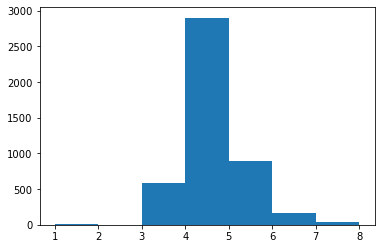

In [23]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

# Ejemplos de uso
## Instanciar el grafo

In [2]:
# Leemos archivos
path = 'data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep = ';')
geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

# Hacemos un set con todos los nodos
S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    S.add(origin)
    S.add(dest)

# Les damos un id relativo a su orden y definimos los diccionarios id_ e _id
S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

# Se instancia el grafo con los ids relativos
G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    G.add_edge(id_[origin], id_[dest])

# Cantidad de nodos    
N = l

# Listas de pesos y de nodos ya visitados
W = [0 for u in range(N)]
V = [0 for u in range(N)]

# Se instancian pesos de las aristas desde el csv
for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

## Algunos ejemplos de uso de códigos para obtener y visualizar resultados

Máximo de nodos por ideal: 460


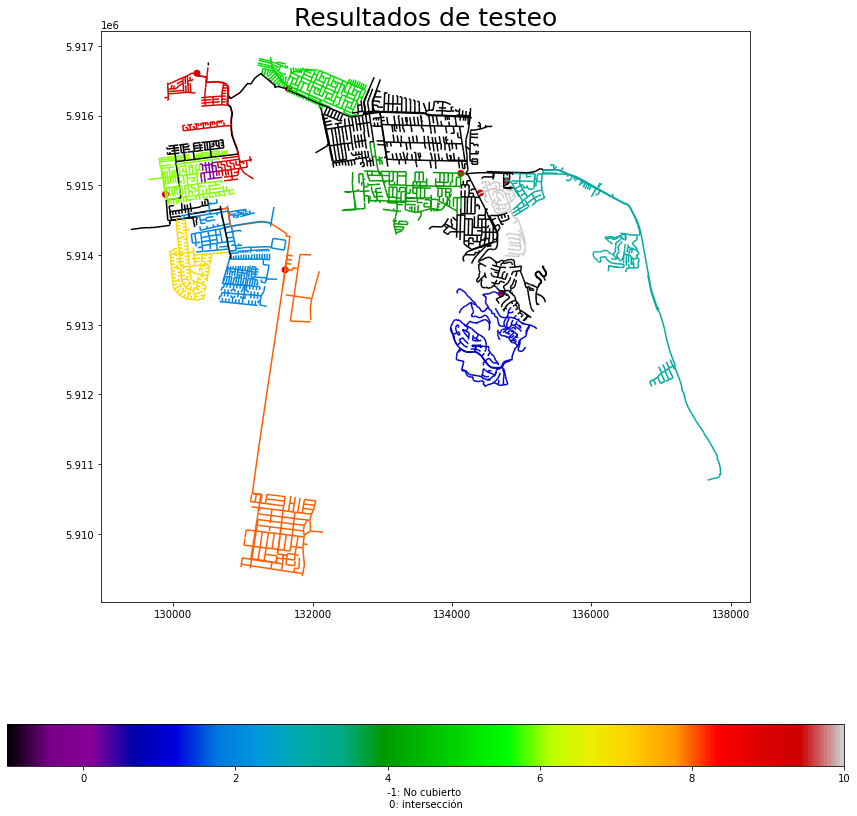

In [3]:
max_nodes = N // 10
print(f'Máximo de nodos por ideal: {max_nodes}')
# Calculamos la solución a través de greedyApp y la visualizamos
ans = greedyApp(G, W, [0] * N, 10, max_nodes, 1e7)
plot_solution(ans, G, N, geometry, _id)

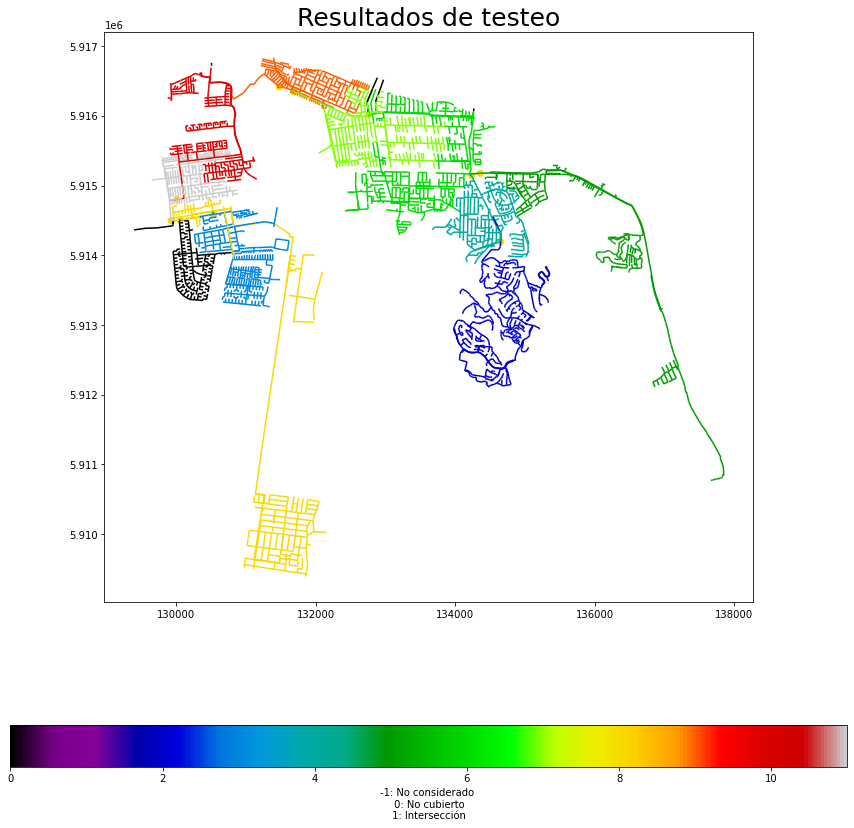

In [4]:
ans, _ = greedyAppReduceDynamic(G, W, [0] * N, 10, 300, 1e7)
plot_sample_no_intersections(G, [0] * N, ans, geometry, _id)

## Djikstra para limpiar grafo

La función distance recibe una fila de un GeoPandas DataFrame. Esta construida la función para que el objeto geométrico a evaluar sea un Linestring. A partir de esto busca retornar la distancia entre estos dos puntos. En caso de que no se pueda, asignará un valor arbitratio previamente definido. En nuestro caso se usó la media del resto de las aristas para determinar este valor. Este procedimiento se describe en la celda siguiente.

In [5]:
def distance(row, mean_weights):
    try:
        x_1 = row['geometry'].coords[0][0]
        y_1 = row['geometry'].coords[0][1]
        x_2 = row['geometry'].coords[1][0]
        y_2 = row['geometry'].coords[1][1]
        return (x_1 - x_2)**2 + (y_1 - y_2)**2 
    except:
        return mean_weights

Código utilizado para filtrar aristas que no correspondían al camino más corto hacia la salida del grafo.

In [6]:
# Leemos archivos
path = 'data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path, sep = ';', GEOM_POSSIBLE_NAMES="geometry",KEEP_GEOM_COLUMNS="NO" )
mean_weights = 3590.47

# Instanciamos
G = nx.DiGraph()
for index, row in geometry.iterrows():
    origin = int(row['self'])
    dest = int(row['other'])
    G.add_edge(origin, dest)
    G[origin][dest]['weight'] = distance(row, mean_weights)


# Iteramos por todos los nodos para encontrar su camino más corto hacia la salida
salida = 1001544; paths = {}; ignored = list()
for node in G.nodes:
    try:
        paths[node] = nx.algorithms.shortest_paths.weighted.single_source_dijkstra(G, node, salida, weight = 'weight')[1]
    except:
        ignored.append(node)

In [7]:
weights = 0 
for i in G.edges(data=True):
    weights += i[2]['weight']
mean_weights = weights / (len(G.edges) - len(ignored))
mean_weights

3597.8943638760197

In [8]:
inicial = geometry.shape[0]
dropped = list()
for i, row in geometry.iterrows():
    origin = int(row['self'])
    dest = int(row['other'])
    if origin not in ignored:
        # Eliminamos aristas que no están en el camino más corto hacia el sumidero
        if dest not in paths[origin]:
            geometry = geometry.drop(index = i)
            dropped.append(i)
geometry.to_csv('data/corrected_dijkstra.csv')
final = geometry.shape[0]
print(f'Se eliminaron {inicial - final} aristas')

Se eliminaron 262 aristas


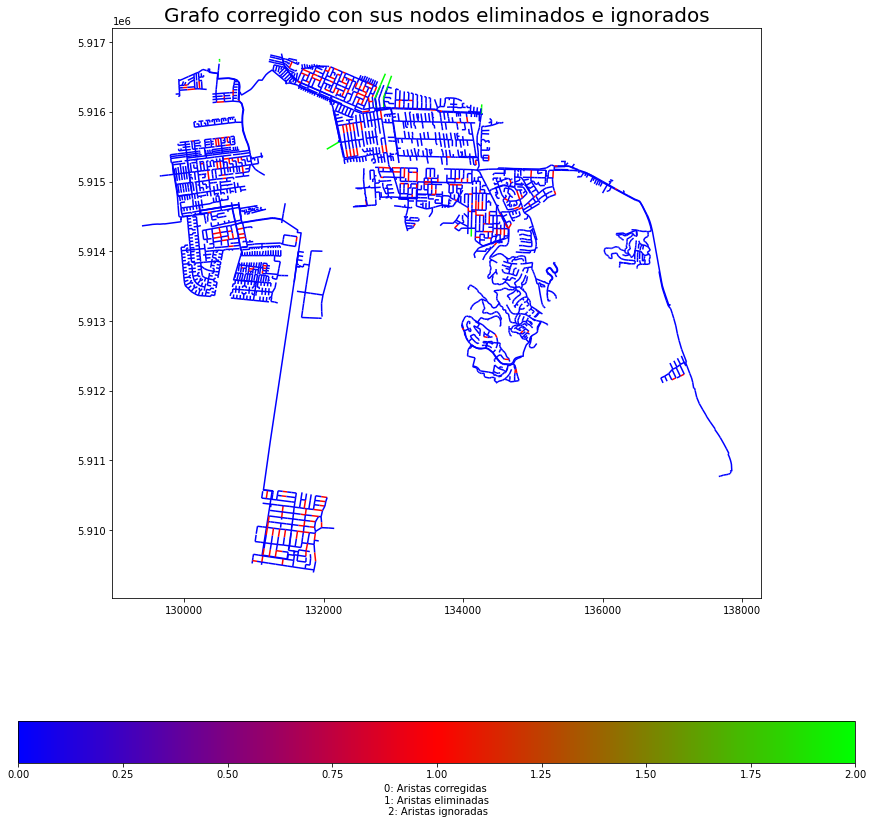

In [9]:
# nodos ignorados
path = 'data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
path = 'data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep = ';')

csv_grafo['color'] = 0

for drop in dropped:
    csv_grafo.at[drop, 'color'] =  1

for ign in ignored:
    csv_grafo.loc[csv_grafo['self'] ==  ign , 'color'] = 2
    csv_grafo.loc[csv_grafo['other'] ==  ign , 'color'] = 2

geometry['color'] = csv_grafo['color'] 


f, ax = plt.subplots(figsize=(15, 15))
ax.set_title(f'Grafo corregido con sus nodos eliminados e ignorados', fontsize=20)

ax = geometry.plot(ax = ax, column = 'color',
                   figsize=(15, 15),
                   legend = True,
                   legend_kwds={'label': "0: Aristas corregidas \n 1: Aristas eliminadas \n 2: Aristas ignoradas", 'orientation': "horizontal"},
                   cmap = 'brg',)

## Análisis de sensibilidad de soluciones

Se parte instanciando ambos grafos: el original y el corregido. Se definen sus respectivos diccionarios, N y sus grafos.

In [21]:
path_original = 'data/graph_geom_corrected_cycles.csv'
csv_original = pd.read_csv(path_original, sep = ';')
geometry_original = gpd.read_file(path_original, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {15190, 1003206, 16503, 15004, 14062, 13735, 1003167, 1003744, 1003746, 1003950, 13730, 13731, 13732, 13733, 15131, 16094, 16095, 131099}

S = set()
for index, row in csv_original.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_o = {}; o_id = {}; l = 0
for u in S:
    id_o[u] = l; o_id[l] = u
    l += 1

G_original = nx.DiGraph()
for index, row in csv_original.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G_original.add_edge(id_o[origin], id_o[dest])
    
N_o = l

W = [0 for u in range(N_o)]
V_o = [0 for u in range(N_o)]

for u in range(N_o):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [22]:
path_arbol = 'data/corrected_dijkstra.csv'
csv_arbol = pd.read_csv(path_arbol)
geometry_arbol = gpd.read_file(path_arbol, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO").drop(["field_1"], axis=1)

S = set()
for index, row in csv_arbol.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_a = {}; a_id = {}; l = 0
for u in S:
    id_a[u] = l; a_id[l] = u
    l += 1

G_arbol = nx.DiGraph()
for index, row in csv_arbol.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G_arbol.add_edge(id_a[origin], id_a[dest])
    
N_a = l

W_a = [0 for u in range(N_a)]
V_a = [0 for u in range(N_a)]

for u in range(N_a):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W_a[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

Se consideran las primeras 5 etapas. Lo que se hace es para cada etapa se obtienen las soluciones dentro del grafo original. Luego se compara el tamano de los ideales inducidos dentro de los nodos no visitados en ambos grafos y se registra su diferencia. Se calcula su promedio de diferencia porcentual. Además, se filtran los valores que se pasan sobre el 50% del valor del ideal ya que se consideran como datos anómalos. Se comenta procedimiento para la primera etapa. Las siguientes son análogas.

In [23]:
k_1 = 8; k_2 = 5
epsilon = 0.1
# Diferencia porcentual
Dif_1 = list(); Dif_2 = list(); Dif_3 = list(); Dif_4 = list(); Dif_5 = list()
# Diferencia porcentual excluyendo ideales con diferencias mayores a 0.5 veces el ideal original 
dif_1 = list(); dif_2 = list(); dif_3 = list(); dif_4 = list(); dif_5 = list()
# Diferencia real
D1 = list(); D2 = list(); D3 = list(); D4 = list(); D5 = list()
# Cantidad de valores filtrados por etapa
S1 = 0; S2 = 0; S3 = 0; S4 =0; S5 = 0
V_o = [0 for u in range(N_o)]; V_a = [0 for u in range(N_a)]


# DESCOMENTAR PARA HACER EL MISMO ANÁLISIS PERO OBTENIENDO LAS SOLUCIONES DESDE EL GRAFO CORREGIDO

# G_arbol, G_original = G_original, G_arbol
# V_o, V_a = V_a, V_o
# N_o, N_a = N_a, N_o
# o_id, a_id = a_id, o_id
# id_a, id_o = id_o, id_a

# PRIMERA ETAPA
# Primero obtenemos la solución
ans_o, sol_dict_o, sizes_o, sol_ideals_o = greedyAppReduceDynamic_partition(G_original, W, V_o, k_1, 400, 1e7)
# Para cada elemento de la solución definimos el ideal correspondiente dentro del grafo corregido.
for sol_o, ideal_o in sol_ideals_o.items():
        sol_a = id_a[o_id[sol_o]]
        size_o = get_size(G_original, V_o, sol_o)
        # Calculamos la diferencia del tamano de los ideales en ambos grafos.
        d1 = abs(get_size(G_arbol, V_a, sol_a) - size_o)
        D1.append(d1)
        # Si cumple el filtro lo agregamos a la lista que registra las diferencias  relativas
        if size_o == 0:
            continue
        if d1 < size_o * 0.5 + epsilon:
            dif_1.append(d1 / size_o)
            Dif_1.append(d1 / size_o)
        else:
             # En caso contrario registramos que lo hemos ignorado
            S1 += 1
            Dif_1.append(d1 / size_o)

        
        # SEGUNDA ETAPA
        # Agregamos el paso de volver a calcular la lista de visitados para trabajar solamente dentro de este ideal
        V_o_2 = [0 if i in ideal_o else 1 for i in range(N_o)]
        ideal_a = [id_a[o_id[i]] for i in ideal_o] 
        V_a_2 = [0 if i in ideal_a else 1 for i in range(N_a)] 
        ans_o_2, sol_dict_o_2, sizes_o_2, sol_ideals_o_2 = greedyAppReduceDynamic_partition(G_original, W, V_o_2, k_2, 75, 1e7)
        for sol_o, ideal_o in sol_ideals_o_2.items():
            sol_a = id_a[o_id[sol_o]]
            size_o = get_size(G_original, V_o_2, sol_o)
            d2 = abs(get_size(G_arbol, V_a_2, sol_a) - size_o)
            D2.append(d2)
            if size_o == 0:
                continue
            if d2 < size_o * 0.5 + epsilon:
                dif_2.append(d2 / size_o)
                Dif_2.append(d2 / size_o)
            else:
                S2 += 1
                Dif_2.append(d2 / size_o)

            
            # TERCERA ETAPA
            V_o_3 = [0 if i in ideal_o else 1 for i in range(N_o)]
            ideal_a = [id_a[o_id[i]] for i in ideal_o] 
            V_a_3 = [0 if i in ideal_a else 1 for i in range(N_a)] 
            ans_o_3, sol_dict_o_3, sizes_o_3, sol_ideals_o_3 = greedyAppReduceDynamic_partition(G_original, W, V_o_3, k_2, 20, 1e7)
            for sol_o, ideal_o in sol_ideals_o_3.items():
                sol_a = id_a[o_id[sol_o]]
                size_o = get_size(G_original, V_o_3, sol_o)
                d3 = abs(get_size(G_arbol, V_a_3, sol_a) - size_o)
                D3.append(d3)
                if size_o == 0:
                    continue
                if d3 < size_o * 0.5 + epsilon:
                    dif_3.append(d3 / size_o)
                    Dif_3.append(d3 / size_o)
                else:
                    S3 += 1
                    Dif_3.append(d3 / size_o)
             
                
                # CUARTA ETAPA
                V_o_4 = [0 if i in ideal_o else 1 for i in range(N_o)]
                ideal_a = [id_a[o_id[i]] for i in ideal_o] 
                V_a_4 = [0 if i in ideal_a else 1 for i in range(N_a)] 
                ans_o_4, sol_dict_o_4, sizes_o_4, sol_ideals_o_4 = greedyAppReduceDynamic_partition(G_original, W, V_o_3, k_2, 10, 1e7)
                for sol_o, ideal_o in sol_ideals_o_4.items():
                    sol_a = id_a[o_id[sol_o]]
                    size_o = get_size(G_original, V_o_4, sol_o)
                    d4 = abs(get_size(G_arbol, V_a_4, sol_a) - size_o)
                    D4.append(d4)
                    if size_o == 0:
                        continue
                    if d4 < size_o * 0.5 + epsilon:
                        dif_4.append(d4 / size_o)
                        Dif_4.append(d4 / size_o)
                    else:
                        S4 += 1
                        Dif_4.append(d4 / size_o)

                    
                    # QUINTA ETAPA
                    V_o_5 = [0 if i in ideal_o else 1 for i in range(N_o)]
                    ideal_a = [id_a[o_id[i]] for i in ideal_o] 
                    V_a_5 = [0 if i in ideal_a else 1 for i in range(N_a)] 
                    ans_o_5, sol_dict_o_5, sizes_o_5, sol_ideals_o_5 = greedyAppReduceDynamic_partition(G_original, W, V_o_4, k_2, 2, 1e7)
                    for sol_o, ideal_o in sol_ideals_o_5.items():
                        sol_a = id_a[o_id[sol_o]]
                        size_o = get_size(G_original, V_o_5, sol_o)
                        d5 = abs(get_size(G_arbol, V_a_5, sol_a) - size_o)
                        D5.append(d5)
                        if size_o == 0:
                            continue
                        if d5 < size_o * 0.5 + epsilon:
                            dif_5.append(d5 / size_o)
                            Dif_5.append(d5 / size_o)
                        else:
                            S5 += 1
                            Dif_5.append(d5 / size_o)
                            

In [24]:
print(f'ETAPA 1 -> Ignorados: {S1}, promedio sin ignorar: {round(sum(Dif_1) / len(Dif_1), 4)*100}% promedio ignorando: {round(sum(dif_1) / len(dif_1), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {S2}, promedio sin ignorar: {round(sum(Dif_2) / len(Dif_2), 4)*100}% promedio ignorando: {round(sum(dif_2) / len(dif_2), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {S3}, promedio sin ignorar: {round(sum(Dif_3) / len(Dif_3), 4)*100}% promedio ignorando: {round(sum(dif_3) / len(dif_3), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {S4}, promedio sin ignorar: {round(sum(Dif_4) / len(Dif_4), 4)*100}% promedio ignorando: {round(sum(dif_4) / len(dif_4), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {S5}, promedio sin ignorar: {round(sum(Dif_5) / len(Dif_5), 4)*100}% promedio ignorando: {round(sum(dif_5) / len(dif_5), 4)*100}%')

ETAPA 1 -> Ignorados: 1, promedio sin ignorar: 13.08% promedio ignorando: 0.79%
ETAPA 1 -> Ignorados: 3, promedio sin ignorar: 10.93% promedio ignorando: 3.35%
ETAPA 1 -> Ignorados: 12, promedio sin ignorar: 11.98% promedio ignorando: 4.54%
ETAPA 1 -> Ignorados: 6, promedio sin ignorar: 6.05% promedio ignorando: 3.4000000000000004%
ETAPA 1 -> Ignorados: 6, promedio sin ignorar: 4.17% promedio ignorando: 2.9899999999999998%


In [25]:
# Diferencias

T = G_arbol; N = N_a

diff = [[] for i in range(5)]
diff_p = [[] for i in range(5)]
diff_pf = [[] for i in range(5)]

V1 = [0] * N

s = None; mx = 0
for u in range(N):
    ss = get_size(T, [0] * N, u)
    if ss > mx:
        mx = ss
        s = u

possibilities, next_dicts = get_dp_table(T, V1, 8, s, 50)
P1, _ = get_sample_from_table(T, possibilities, next_dicts, V1, 8, s)

for u1 in P1[::-1]:
        
    d = abs(get_size(G, V1, u1) - get_size(T, V1, u1))
    diff[0].append(d)
    diff_p[0].append(d / get_size(T, V1, u1))
    
    if d <= get_size(T, V1, u1) * 0.5 :
        diff_pf[0].append(d / get_size(T, V1, u1))

    I = set(get_ideal(T, V1, u1))
    V2 = [not (v in I) for v in range(N)]

    possibilities, next_dicts = get_dp_table(T, V2, 5, u1, 20)
    P2, _ = get_sample_from_table(T, possibilities, next_dicts, V2, 5, u1)

    for u2 in P2[::-1]:
            
        d = abs(get_size(G, V2, u2) - get_size(T, V2, u2))
        diff[1].append(d)
        diff_p[1].append(d / get_size(T, V2, u2))
                
        if d <= get_size(T, V2, u2) * 0.5 :
            diff_pf[1].append(d / get_size(T, V2, u2))

        I = set(get_ideal(T, V2, u2))
        V3 = [not (v in I) for v in range(N)]

        possibilities, next_dicts = get_dp_table(T, V3, 5, u2, 10)
        P3, _ = get_sample_from_table(T, possibilities, next_dicts, V3, 5, u2)
        
        for u3 in P3[::-1]:
            
            d = abs(get_size(G, V3, u3) - get_size(T, V3, u3))
            diff[2].append(d)
            diff_p[2].append(d / get_size(T, V3, u3))

            if d <= get_size(T, V3, u3) * 0.5 :
                diff_pf[2].append(d / get_size(T, V3, u3))

            I = set(get_ideal(T, V3, u3))
            V4 = [not (v in I) for v in range(N)]

            possibilities, next_dicts = get_dp_table(T, V4, min(5, N - sum(V4)), u3, 5)
            P4, _ = get_sample_from_table(T, possibilities, next_dicts, V4, min(5, N - sum(V4)), u3)
            
            for u4 in P4[::-1]:
                
                d = abs(get_size(G, V4, u4) - get_size(T, V4, u4))
                diff[3].append(d)
                diff_p[3].append(d / get_size(T, V4, u4))

                if d <= get_size(T, V4, u4) * 0.5 :
                    diff_pf[3].append(d / get_size(T, V4, u4))

                I = set(get_ideal(T, V4, u4))
                V5 = [not (v in I) for v in range(N)]

                possibilities, next_dicts = get_dp_table(T, V5, min(5, N - sum(V5)), u4, 1)
                P5, _ = get_sample_from_table(T, possibilities, next_dicts, V5, min(5, N - sum(V5)), u4)
                
                for u5 in P5[::-1]:
                    
                    d = abs(get_size(G, V5, u5) - get_size(T, V5, u5))
                    diff[4].append(d)
                    diff_p[4].append(d / get_size(T, V5, u5))
                    
                    if d <= get_size(T, V5, u5) * 0.5 :
                        diff_pf[4].append(d / get_size(T, V5, u5))
                    
                    V5, _ = visit(T, V5, u5)
                V4, _ = visit(T, V4, u4)
            V3, _ = visit(T, V3, u3)
        V2, _ = visit(T, V2, u2)
    V1, _ = visit(T, V1, u1)

In [26]:
print(f'ETAPA 1 -> Ignorados: {len(diff_p[0]) - len(diff_pf[0])}, promedio sin ignorar: {round(sum(diff_p[0]) / len(diff_p[0]), 4)*100}% promedio ignorando: {round(sum(diff_pf[0]) / len(diff_pf[0]), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {len(diff_p[1]) - len(diff_pf[1])}, promedio sin ignorar: {round(sum(diff_p[1]) / len(diff_p[1]), 4)*100}% promedio ignorando: {round(sum(diff_pf[1]) / len(diff_pf[1]), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {len(diff_p[2]) - len(diff_pf[2])}, promedio sin ignorar: {round(sum(diff_p[2]) / len(diff_p[2]), 4)*100}% promedio ignorando: {round(sum(diff_pf[2]) / len(diff_pf[2]), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {len(diff_p[3]) - len(diff_pf[3])}, promedio sin ignorar: {round(sum(diff_p[3]) / len(diff_p[3]), 4)*100}% promedio ignorando: {round(sum(diff_pf[3]) / len(diff_pf[3]), 4)*100}%')
print(f'ETAPA 1 -> Ignorados: {len(diff_p[4]) - len(diff_pf[4])}, promedio sin ignorar: {round(sum(diff_p[4]) / len(diff_p[4]), 4)*100}% promedio ignorando: {round(sum(diff_pf[4]) / len(diff_pf[4]), 4)*100}%')

ETAPA 1 -> Ignorados: 1, promedio sin ignorar: 17.130000000000003% promedio ignorando: 5.8500000000000005%
ETAPA 1 -> Ignorados: 2, promedio sin ignorar: 11.23% promedio ignorando: 7.049999999999999%
ETAPA 1 -> Ignorados: 11, promedio sin ignorar: 8.57% promedio ignorando: 3.7699999999999996%
ETAPA 1 -> Ignorados: 19, promedio sin ignorar: 3.09% promedio ignorando: 1.67%
ETAPA 1 -> Ignorados: 3, promedio sin ignorar: 0.48% promedio ignorando: 0.38999999999999996%
